# Packages

In [180]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 

# preparation
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from scipy.stats import skew
from scipy import special #boxcox
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

# Neural Network
import keras
import keras.backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import models
from keras import layers

# ML Models
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import  recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix,roc_curve, auc
from sklearn.model_selection import cross_val_score

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# Explenation
import shap
from lime.lime_tabular import LimeTabularExplainer

# Saving
import pickle


# misc
import warnings
warnings.filterwarnings('ignore')

# Data examination

| Stretch/Untouched | ProbDistribution |
| --- | --- |
| Loan_ID | Unique Loan ID |
| Gender | Male/ Female |
| Married | Applicant married (Y/N) |
| Dependents | Number of dependents |
| Education | Applicant Education (Graduate/ Under Graduate) |
| Self_Employed | Self employed (Y/N) |
| ApplicantIncome | Applicant income |
| CoapplicantIncome | Coapplicant income |
| LoanAmount | Loan amount in thousands |
| Loan_Amount_Term | Term of loan in months|
| Credit_History | credit history meets guidelines |
| Property_Area | Urban/ Semi Urban/ Rural|
| Loan_Status | (Target) Loan approved (Y/N)|


In [3]:
data = pd.read_csv('Loan_Data.csv')

In [4]:
data.head()

Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Rural           N  
2             1.0         Urban           Y  
3             1.0         Urban           Y  
4             1.0         Urban           Y

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [6]:
def ratios(df):
    ratiosdf= pd.DataFrame(zip(df.isnull().sum(),df.isnull().sum()/(len(df)),df.count(axis=0),df.dtypes,df.nunique(axis=0)),columns=['Missing','Ratio','Total','Type','UniqueVals'],index=df.columns)
    return ratiosdf
ratios(data)

Missing     Ratio  Total     Type  UniqueVals
Loan_ID                  0  0.000000    614   object         614
Gender                  13  0.021173    601   object           2
Married                  3  0.004886    611   object           2
Dependents              15  0.024430    599   object           4
Education                0  0.000000    614   object           2
Self_Employed           32  0.052117    582   object           2
ApplicantIncome          0  0.000000    614    int64         505
CoapplicantIncome        0  0.000000    614  float64         287
LoanAmount              22  0.035831    592  float64         203
Loan_Amount_Term        14  0.022801    600  float64          10
Credit_History          50  0.081433    564  float64           2
Property_Area            0  0.000000    614   object           3
Loan_Status              0  0.000000    614   object           2

In [7]:
vc=data['Loan_Status'].value_counts().reset_index(name='Count')
ratio = round(vc['Count'][1]/len(data),2)
ratio
#There is impalance in the dataset

0.31

# TrainTest

In [8]:
X= data.drop(columns=['Loan_Status'])
y=data['Loan_Status']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42, stratify=y)

Train=pd.concat((X_train,y_train),axis=1)
Test=pd.concat((X_test,y_test),axis=1)

In [9]:
# Ratio doublecheck

print('Event rate in the training dataset : ',round(Train['Loan_Status'].value_counts().reset_index(name='Count')['Count'][1]/len(Train),2))
print('Event rate in the test dataset : ',round(Test['Loan_Status'].value_counts().reset_index(name='Count')['Count'][1]/len(Test),2))
print('Event rate in the entire dataset : ',round(data['Loan_Status'].value_counts().reset_index(name='Count')['Count'][1]/len(data),2))

Event rate in the training dataset :  0.31
Event rate in the test dataset :  0.31
Event rate in the entire dataset :  0.31


# Univariate

Only consider the train dataset for univariate, but double check impact on test set.\
Small changes are allowed. Encoding only when easy.

In [10]:
# print the name of a dataframe

def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [11]:
dataset=[Train,Test]

In [12]:
#split colnames in numerical and categorical lists. 
Numerical = Train.select_dtypes(include=np.number).columns.tolist()
Categorical = Train.select_dtypes(exclude=np.number).columns.tolist()

## Target

In [13]:
Train['Loan_Status'].unique()
# currently this is a categorical variable. 
# there are no missing values. 

array(['Y', 'N'], dtype=object)

In [14]:
# Transfer to numerical
for df in dataset:
    df.loc[df['Loan_Status']=='Y','Loan_Status']=1
    df.loc[df['Loan_Status']=='N','Loan_Status']=0
    #transfer to numerical variable
    df['Loan_Status']=df['Loan_Status'].astype('Float64')
    print(f"in dataset {get_df_name(df)} there are {round(df['Loan_Status'].mean()*100,1)} % of the cases approved.")

# from now on 1 corresponds with loan appoved, 0 with loan rejected. Ratio is good. 

in dataset Train there are 68.6 % of the cases approved.
in dataset Test there are 69.1 % of the cases approved.


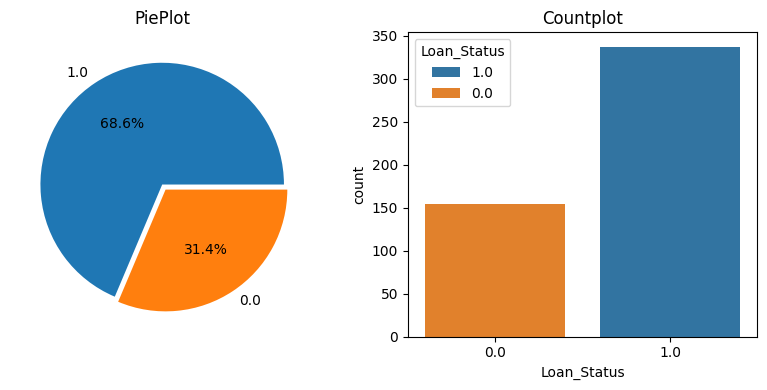

In [15]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(8,4))

sns.countplot(data=Train,x='Loan_Status',ax=ax[1],hue='Loan_Status',hue_order = [1.0, 0.0])
ax[1].set_title('Countplot')
labels= Train['Loan_Status'].value_counts().reset_index()['Loan_Status'].tolist()
colors = ['skyblue', 'salmon']
ax[0].pie(Train['Loan_Status'].value_counts(),explode=[0,0.05],autopct='%1.1f%%',labels=labels)
ax[0].set_title('PiePlot')
plt.tight_layout()


## Categorical

In [16]:
# Function to identify basic information on categorical data. 
def categorical(df,col):
    Categorical = df.select_dtypes(exclude=np.number).columns.tolist()
    categordf= pd.DataFrame(zip(df[col].fillna('nan').value_counts(dropna=False),round(df[col].fillna('nan').value_counts(dropna=False)/len(df),2),round(df.fillna('nan').groupby(col)['Loan_Status'].mean(),2)),columns=['Count','Ratio','LoanRatio'],index=df[col].unique())
    print (categordf)
    print (f"Number of missing values: {df[col].isnull().sum()}")

    plt.figure(figsize=(5,3))
    sns.countplot(data=df.fillna('NaN'),x=col, hue=col)
    plt.title(f'Countplot of {col}')
    plt.show()      
    return 

In [17]:
ratios(Train[Categorical])

Missing     Ratio  Total     Type  UniqueVals
Loan_ID              0  0.000000    491   object         491
Gender              11  0.022403    480   object           2
Married              3  0.006110    488   object           2
Dependents           8  0.016293    483   object           4
Education            0  0.000000    491   object           2
Self_Employed       27  0.054990    464   object           2
Property_Area        0  0.000000    491   object           3
Loan_Status          0  0.000000    491  Float64           2

In [18]:
# Loan_ID is a administrative column and will be discarded. 
for df in dataset:
    df.drop(columns=['Loan_ID'],inplace=True)


        Count  Ratio  LoanRatio
Male      393   0.80       0.70
Female     87   0.18       0.68
NaN        11   0.02       0.64
Number of missing values: 11


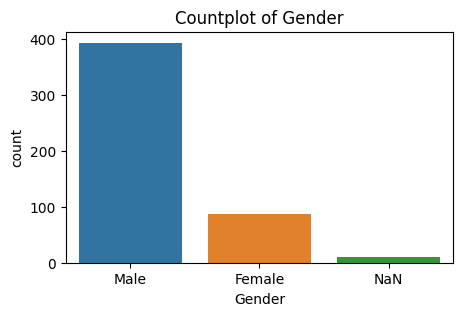

In [19]:
# Gender, 11 missing values
categorical(Train,'Gender')



     Count  Ratio  LoanRatio
No     319   0.65       0.64
Yes    169   0.34       0.71
NaN      3   0.01       1.00
Number of missing values: 3


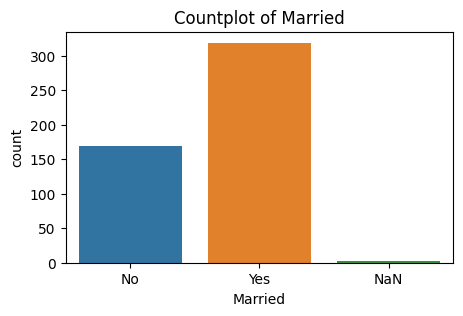

In [20]:
# Married
categorical(Train,'Married')

     Count  Ratio  LoanRatio
0      276   0.56       0.68
1       85   0.17       0.66
2       83   0.17       0.75
NaN     39   0.08       0.67
3+       8   0.02       0.75
Number of missing values: 8


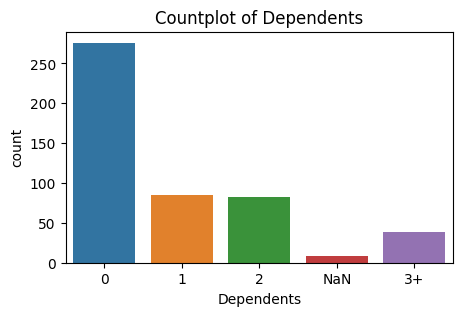

In [21]:
# Dependents
categorical(Train,'Dependents')

              Count  Ratio  LoanRatio
Graduate        380   0.77       0.71
Not Graduate    111   0.23       0.61
Number of missing values: 0


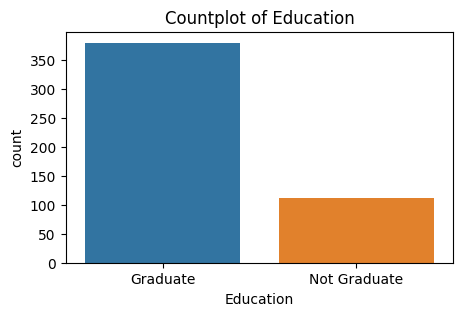

In [22]:
# Education
categorical(Train,'Education')

     Count  Ratio  LoanRatio
No     398   0.81       0.69
Yes     66   0.13       0.67
NaN     27   0.05       0.70
Number of missing values: 27


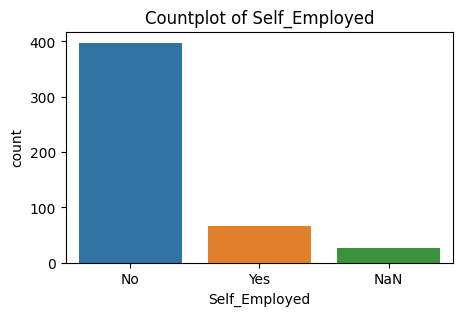

In [23]:
# Self_Employed
categorical(Train,'Self_Employed')

           Count  Ratio  LoanRatio
Urban        184   0.37       0.61
Semiurban    162   0.33       0.78
Rural        145   0.30       0.65
Number of missing values: 0


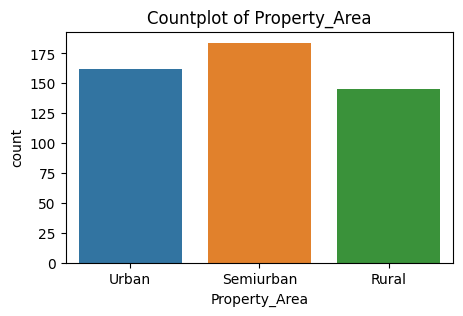

In [24]:
# Property_Area
categorical(Train,'Property_Area')

## Numerical

In [25]:
ratios(Train[Numerical])

Missing     Ratio  Total     Type  UniqueVals
ApplicantIncome          0  0.000000    491    int64         416
CoapplicantIncome        0  0.000000    491  float64         232
LoanAmount              20  0.040733    471  float64         185
Loan_Amount_Term        12  0.024440    479  float64          10
Credit_History          43  0.087576    448  float64           2

In [26]:
# Function to identify basic information on numerical data. 
def numerical(df,col):
    fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(12,4))
    sns.histplot(data=df,x=col,ax=ax[0],kde=True)
    ax[0].set_title(f'Histogram of {col}')

    sns.boxplot(data=df,y=col,ax=ax[1],orient='v')
    ax[1].set_title(f'Boxplot of {col}')
    ax[1].set_xlabel(f'{col}')
    sns.boxplot(data=df,y=col,x='Loan_Status',ax=ax[2],orient='v',hue='Loan_Status')
    ax[2].set_title(f'Split Boxplot of {col}')
    ax[2].get_legend().remove()
    plt.tight_layout()
    plt.show()

    print (f"Number of missing values: {df[col].isnull().sum()}")

    print(df[col].describe())




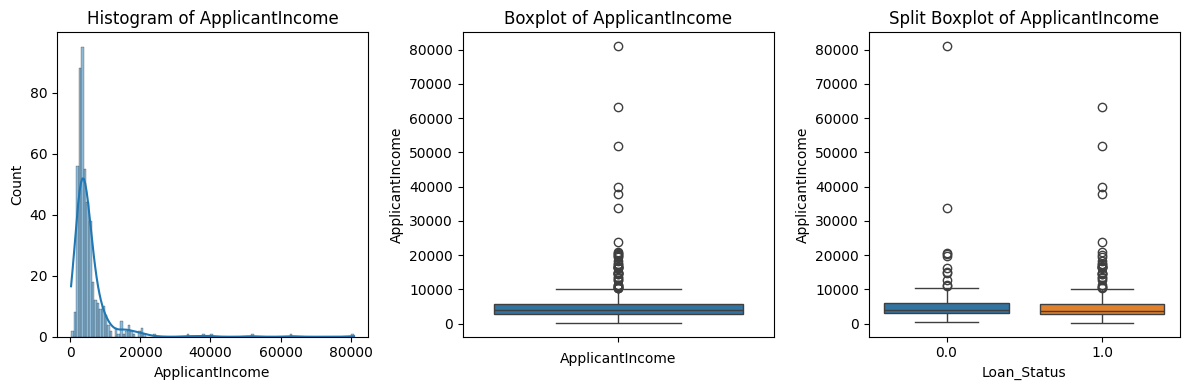

Number of missing values: 0
count      491.000000
mean      5529.997963
std       6457.784318
min        210.000000
25%       2906.000000
50%       3859.000000
75%       5825.000000
max      81000.000000
Name: ApplicantIncome, dtype: float64


In [27]:
#ApplicantIncome

numerical(Train,'ApplicantIncome')

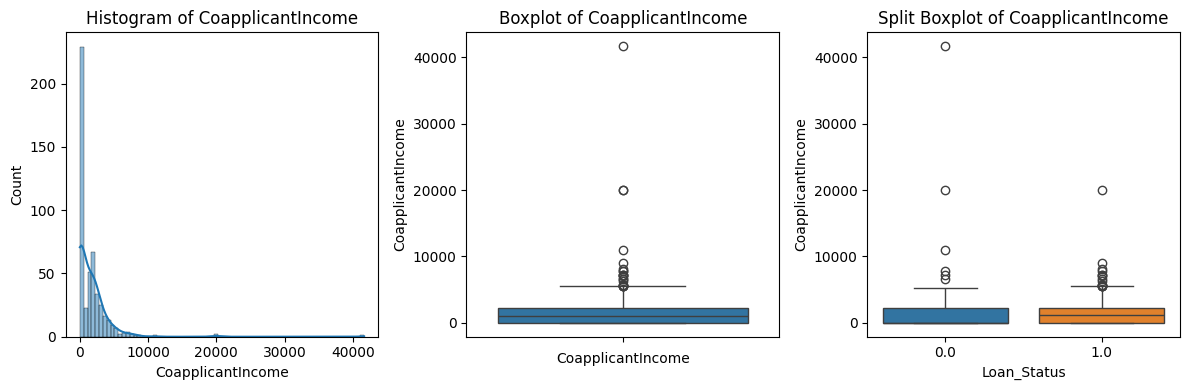

Number of missing values: 0
count      491.000000
mean      1569.537271
std       2789.523475
min          0.000000
25%          0.000000
50%       1032.000000
75%       2241.000000
max      41667.000000
Name: CoapplicantIncome, dtype: float64


In [28]:
#CoapplicantIncome

numerical(Train,'CoapplicantIncome')

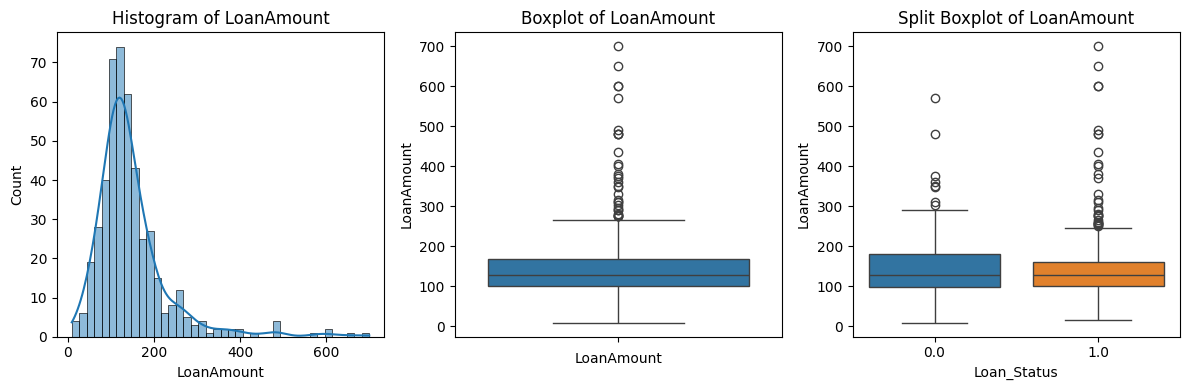

Number of missing values: 20
count    471.000000
mean     147.309979
std       87.096507
min        9.000000
25%      100.000000
50%      128.000000
75%      168.000000
max      700.000000
Name: LoanAmount, dtype: float64


In [29]:
#LoanAmount

numerical(Train,'LoanAmount')

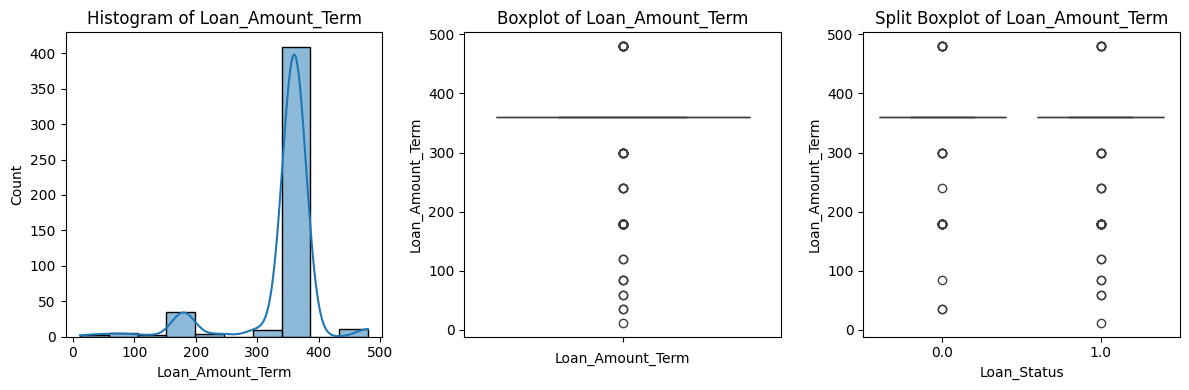

Number of missing values: 12
count    479.000000
mean     341.286013
std       65.855043
min       12.000000
25%      360.000000
50%      360.000000
75%      360.000000
max      480.000000
Name: Loan_Amount_Term, dtype: float64


In [30]:
#Loan_Amount_Term
# Term of loan in months. 

numerical(Train,'Loan_Amount_Term')

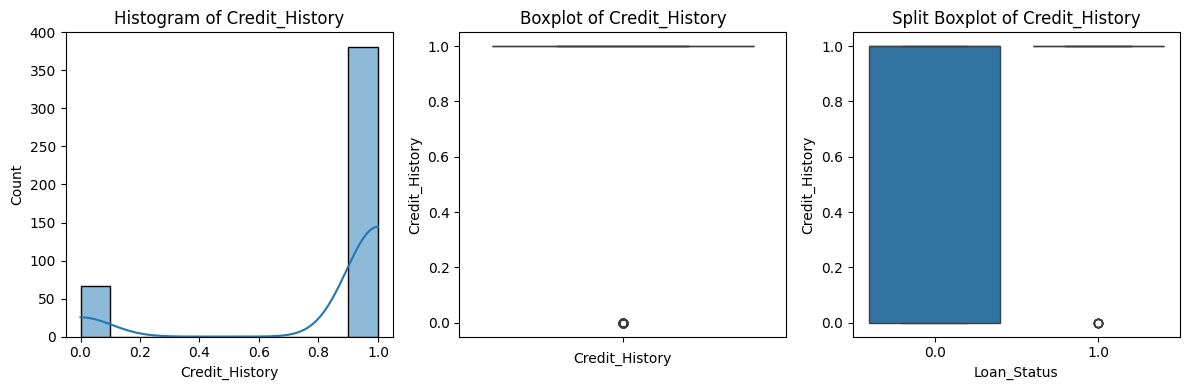

Number of missing values: 43
count    448.000000
mean       0.850446
std        0.357032
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: Credit_History, dtype: float64
     Count  Ratio  LoanRatio
1.0    381   0.78       0.09
0.0     67   0.14       0.79
NaN     43   0.09       0.70
Number of missing values: 43


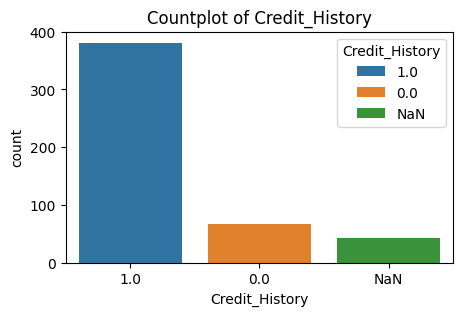

In [31]:
#Credit_History
#This is actually a  categorical variable:  credit history meets guidelines
numerical(Train,'Credit_History')
categorical(Train,'Credit_History')

# Outliers values

In [32]:
dataset=[Train,Test]

In [33]:
quantiles=[0,0.25,0.50,0.75,0.90,0.95,0.96,0.97,0.98,0.99,0.995,1]
def quant_analysis(df,col,quantiles=quantiles):
    quantile_values=df[col].quantile(quantiles).reset_index()
    quantile_values = quantile_values.rename(columns={'index': 'Quantile'})
    quantile_values['Qty']=quantile_values['Quantile'].apply(lambda x: round(len(df[col])*x,2))
    length=round(len(df[col]),2)
    print(f'Number of values: {length}')
    numerical_ana = numerical(df,col)
    return quantile_values, numerical_ana

Number of times CoappliantIncome is larger than ApplicantIncome: 55
Number of values: 982


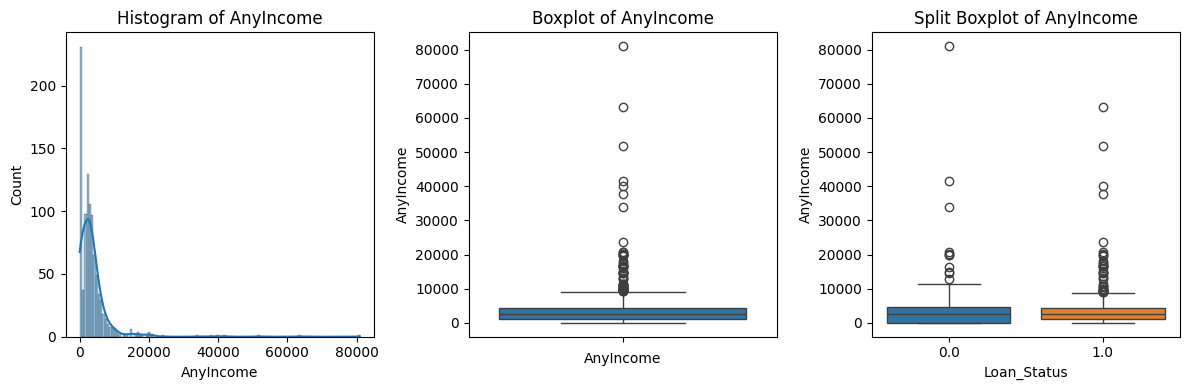

Number of missing values: 0
count      982.000000
mean      3549.767617
std       5351.849944
min          0.000000
25%       1011.000000
50%       2600.000000
75%       4300.750000
max      81000.000000
Name: AnyIncome, dtype: float64


In [34]:
#ApplicantIncome & Coapplicantincome
#Count number of times ApplicantIncome>Coappliantincome and vice versa
def count_income(row):
    global diff_count
    if row['CoapplicantIncome'] > row['ApplicantIncome']:
        diff_count += 1

diff_count=0
Train.apply(count_income,axis=1)
print(f'Number of times CoappliantIncome is larger than ApplicantIncome: {diff_count}') 
# in approx 11 percent of the cases higher Coappliant Income. 
# indication that income is not filled in based on second or first, but random. 
# therefore outliers analysis on all income values. 

Income=pd.concat([Train[['ApplicantIncome','Loan_Status']],Train[['CoapplicantIncome', 'Loan_Status']]]).reset_index()
Income['AnyIncome']=Income.apply(lambda row: row['CoapplicantIncome'] if pd.notnull(row['CoapplicantIncome']) else row['ApplicantIncome'],axis=1 )

quant_analysis(Income,'AnyIncome')


# Based on results mark everything greater than 37935.60 as  37935.60. 
for df in dataset:
    df.loc[df['ApplicantIncome']>37935.60,'ApplicantIncome']=37935.60
    df.loc[df['CoapplicantIncome']>37935.60,'CoapplicantIncome']=37935.60


Number of values: 491


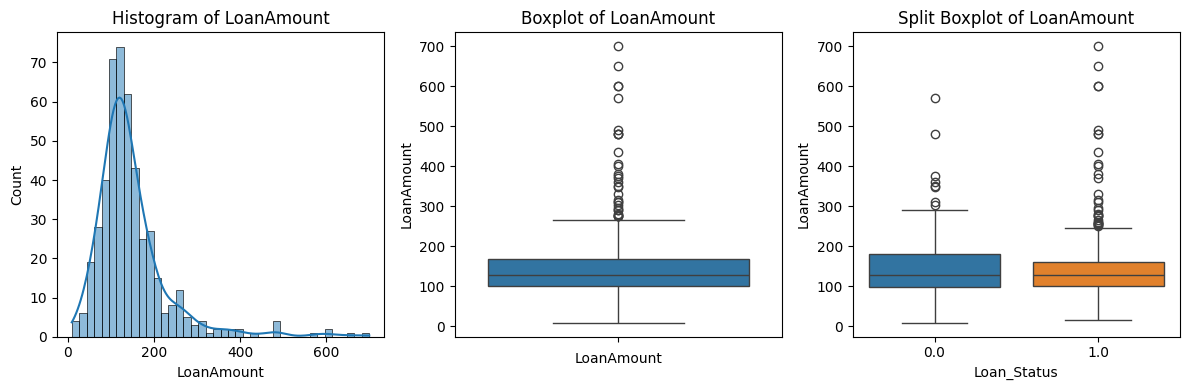

Number of missing values: 20
count    471.000000
mean     147.309979
std       87.096507
min        9.000000
25%      100.000000
50%      128.000000
75%      168.000000
max      700.000000
Name: LoanAmount, dtype: float64


In [35]:
#LoanAmount
quant_analysis(Train,'LoanAmount')

# Based on results mark everything greater than 423.6 as  423.6. 
for df in dataset:
    df.loc[df['LoanAmount']>423.6,'LoanAmount']=423.6

Number of values: 491


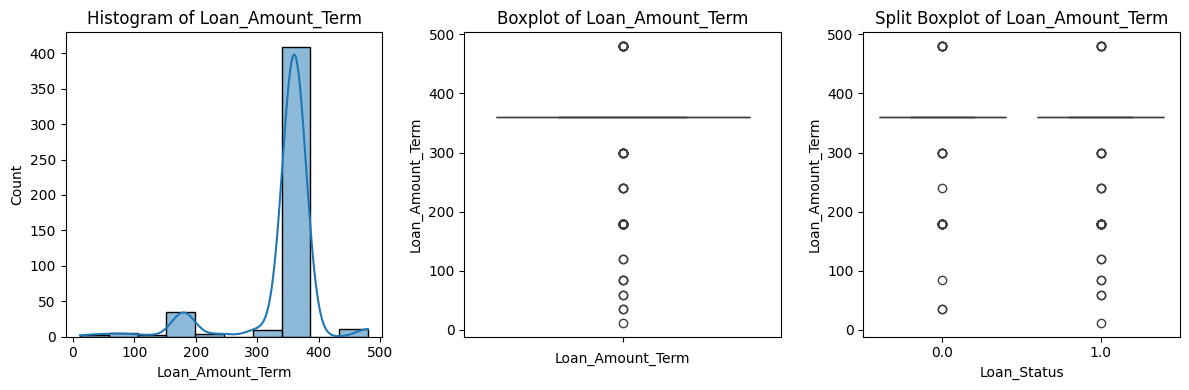

Number of missing values: 12
count    479.000000
mean     341.286013
std       65.855043
min       12.000000
25%      360.000000
50%      360.000000
75%      360.000000
max      480.000000
Name: Loan_Amount_Term, dtype: float64


Loan_Amount_Term
360.0    409
180.0     35
480.0     11
300.0     10
240.0      4
84.0       3
60.0       2
120.0      2
36.0       2
12.0       1
Name: count, dtype: int64

In [36]:
#Loan_Amount_Term
quant_analysis(Train,'Loan_Amount_Term')
# most applicants have a 360 month loan. 
# rest is outliers. 

Train['Loan_Amount_Term'].value_counts()
#all values do seem realistic as they can be divided by 12 (full year)
# therefor no outliers. 

# Missing values Treatment

In [37]:
dataset=[Train,Test]
ratios(Train)


Missing     Ratio  Total     Type  UniqueVals
Gender                  11  0.022403    480   object           2
Married                  3  0.006110    488   object           2
Dependents               8  0.016293    483   object           4
Education                0  0.000000    491   object           2
Self_Employed           27  0.054990    464   object           2
ApplicantIncome          0  0.000000    491  float64         413
CoapplicantIncome        0  0.000000    491  float64         232
LoanAmount              20  0.040733    471  float64         179
Loan_Amount_Term        12  0.024440    479  float64          10
Credit_History          43  0.087576    448  float64           2
Property_Area            0  0.000000    491   object           3
Loan_Status              0  0.000000    491  Float64           2

In [38]:
# Gender
# 11 missing values. no clear difference for NaN values regarding target variable, value does not seem to matter that much. 
# replace NaN values with the Mode since there is a count difference between male and female. 


Train.loc[Train['Gender'].isnull()==True,'Gender']='Male'
Test.loc[Test['Gender'].isnull()==True,'Gender']='Male'



     Count  Ratio  LoanRatio
No     319   0.65       0.64
Yes    169   0.34       0.71
NaN      3   0.01       1.00
Number of missing values: 3


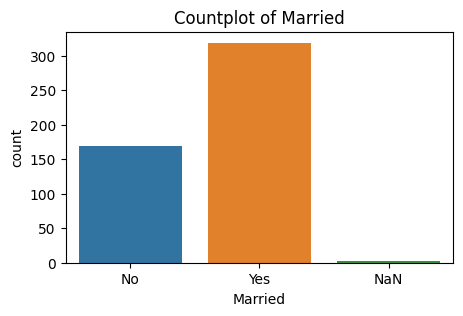

In [39]:
#Married
# 3 missing values. all resulting in loan_status = 1. 
# there is no clear difference between married categories.
categorical(Train,'Married')
Train.loc[Train['Married'].isnull()==True] 

# could be that the presence of a coApplicant, makes it clear that this is a married couple

Train.loc[Train['Married'].isnull()==True] 
#if a coapplicant is present --> Maried, else not married. 


for df in dataset:
    null_married_rows = df['Married'].isnull()
    df.loc[null_married_rows, 'Married']=df.loc[null_married_rows, 'CoapplicantIncome'].apply(lambda x: 'Yes' if x > 1 else 'No')


     Count  Ratio  LoanRatio
0      276   0.56       0.68
1       85   0.17       0.66
2       83   0.17       0.75
NaN     39   0.08       0.67
3+       8   0.02       0.75
Number of missing values: 8


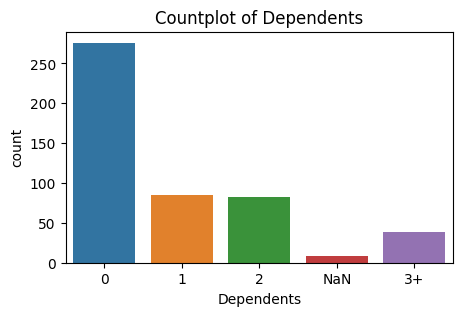

     Count  Ratio  LoanRatio
0.0    244   0.50       0.68
1.0    125   0.25       0.66
2.0     83   0.17       0.75
3.0     39   0.08       0.67
Number of missing values: 0


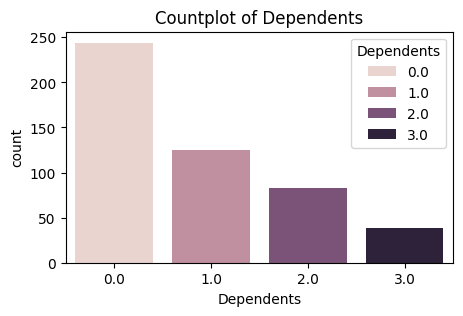

In [40]:
# Dependents
categorical(Train,'Dependents')
# 39 NaN values. 
# check ratio Dependents and Married. 
Train.loc[(Train['Dependents']=='0')&(Train['Married']=='Yes')]

# there are cases where dependents = 0, and married is 'yes'
# if depedents is 0 or NaN and Married is Yes: Depentdents is 1. Else dependents is 0
# transfer to numerical data

for df in dataset:
   df.loc[((df['Dependents']=='0')|(df['Dependents'].isnull()))&(df['Married']=='Yes')&(df['CoapplicantIncome']==0),'Dependents']='1'
   df.loc[(df['Dependents'].isnull()),'Dependents']='0'
   df.loc[(df['Dependents']=='3+'),'Dependents']='3'
   df['Dependents']=df['Dependents'].astype('float64')


categorical(Train,'Dependents')

     Count  Ratio  LoanRatio
No     398   0.81       0.69
Yes     66   0.13       0.67
NaN     27   0.05       0.70
Number of missing values: 27


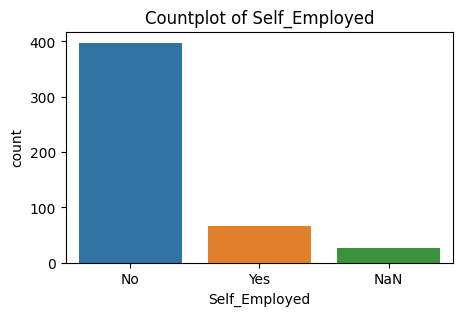

In [41]:
#Self_Employed
categorical(Train,'Self_Employed')

#inputate with Mode

for df in dataset: 
    df.loc[df['Self_Employed'].isnull()==True,'Self_Employed']='No'

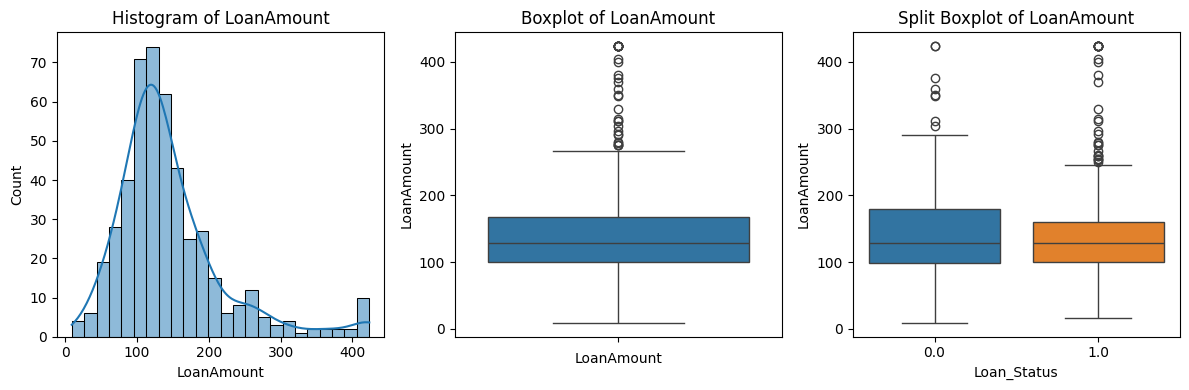

Number of missing values: 20
count    471.000000
mean     144.656051
std       75.029893
min        9.000000
25%      100.000000
50%      128.000000
75%      168.000000
max      423.600000
Name: LoanAmount, dtype: float64
Number of missing values: 20


In [42]:
# LoanAmount

numerical(Train,'LoanAmount')
print(f"Number of missing values: {Train['LoanAmount'].isnull().sum()}")

#impute with mean value from Train set
LoanAmount_mean=round(Train['LoanAmount'].mean(),2)
LoanAmount_mean

for df in dataset: 
    df.loc[df['LoanAmount'].isnull()==True,'LoanAmount']=LoanAmount_mean


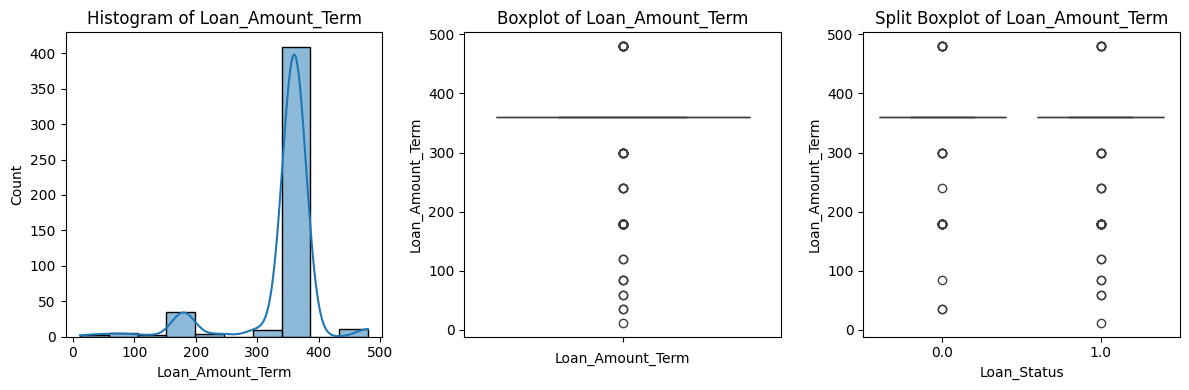

Number of missing values: 12
count    479.000000
mean     341.286013
std       65.855043
min       12.000000
25%      360.000000
50%      360.000000
75%      360.000000
max      480.000000
Name: Loan_Amount_Term, dtype: float64
Number of missing values: 12


In [43]:
# Loan_Amount_Term
numerical(Train,'Loan_Amount_Term')
print(f"Number of missing values: {Train['Loan_Amount_Term'].isnull().sum()}")

#impute with Mode. 

for df in dataset: 
    df.loc[df['Loan_Amount_Term'].isnull()==True,'Loan_Amount_Term']=360

     Count  Ratio  LoanRatio
1.0    381   0.78       0.09
0.0     67   0.14       0.79
NaN     43   0.09       0.70
Number of missing values: 43


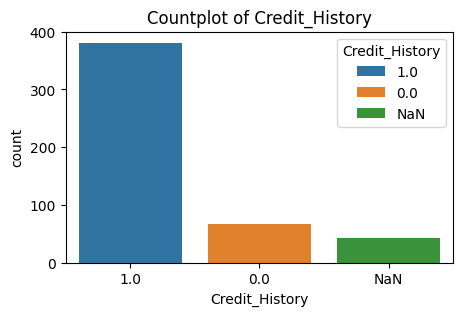

In [44]:
# Credit_History
categorical(Train,'Credit_History')
# approx 9% of data is missing
# note that LoanRatio is close to 0.0. It can be assumed that credit history is not filled and that this is a requirement. 
# impute with 0,0

for df in dataset: 
    df.loc[df['Credit_History'].isnull()==True,'Credit_History']=0.0

In [45]:
Train.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

# Bivariate analysis

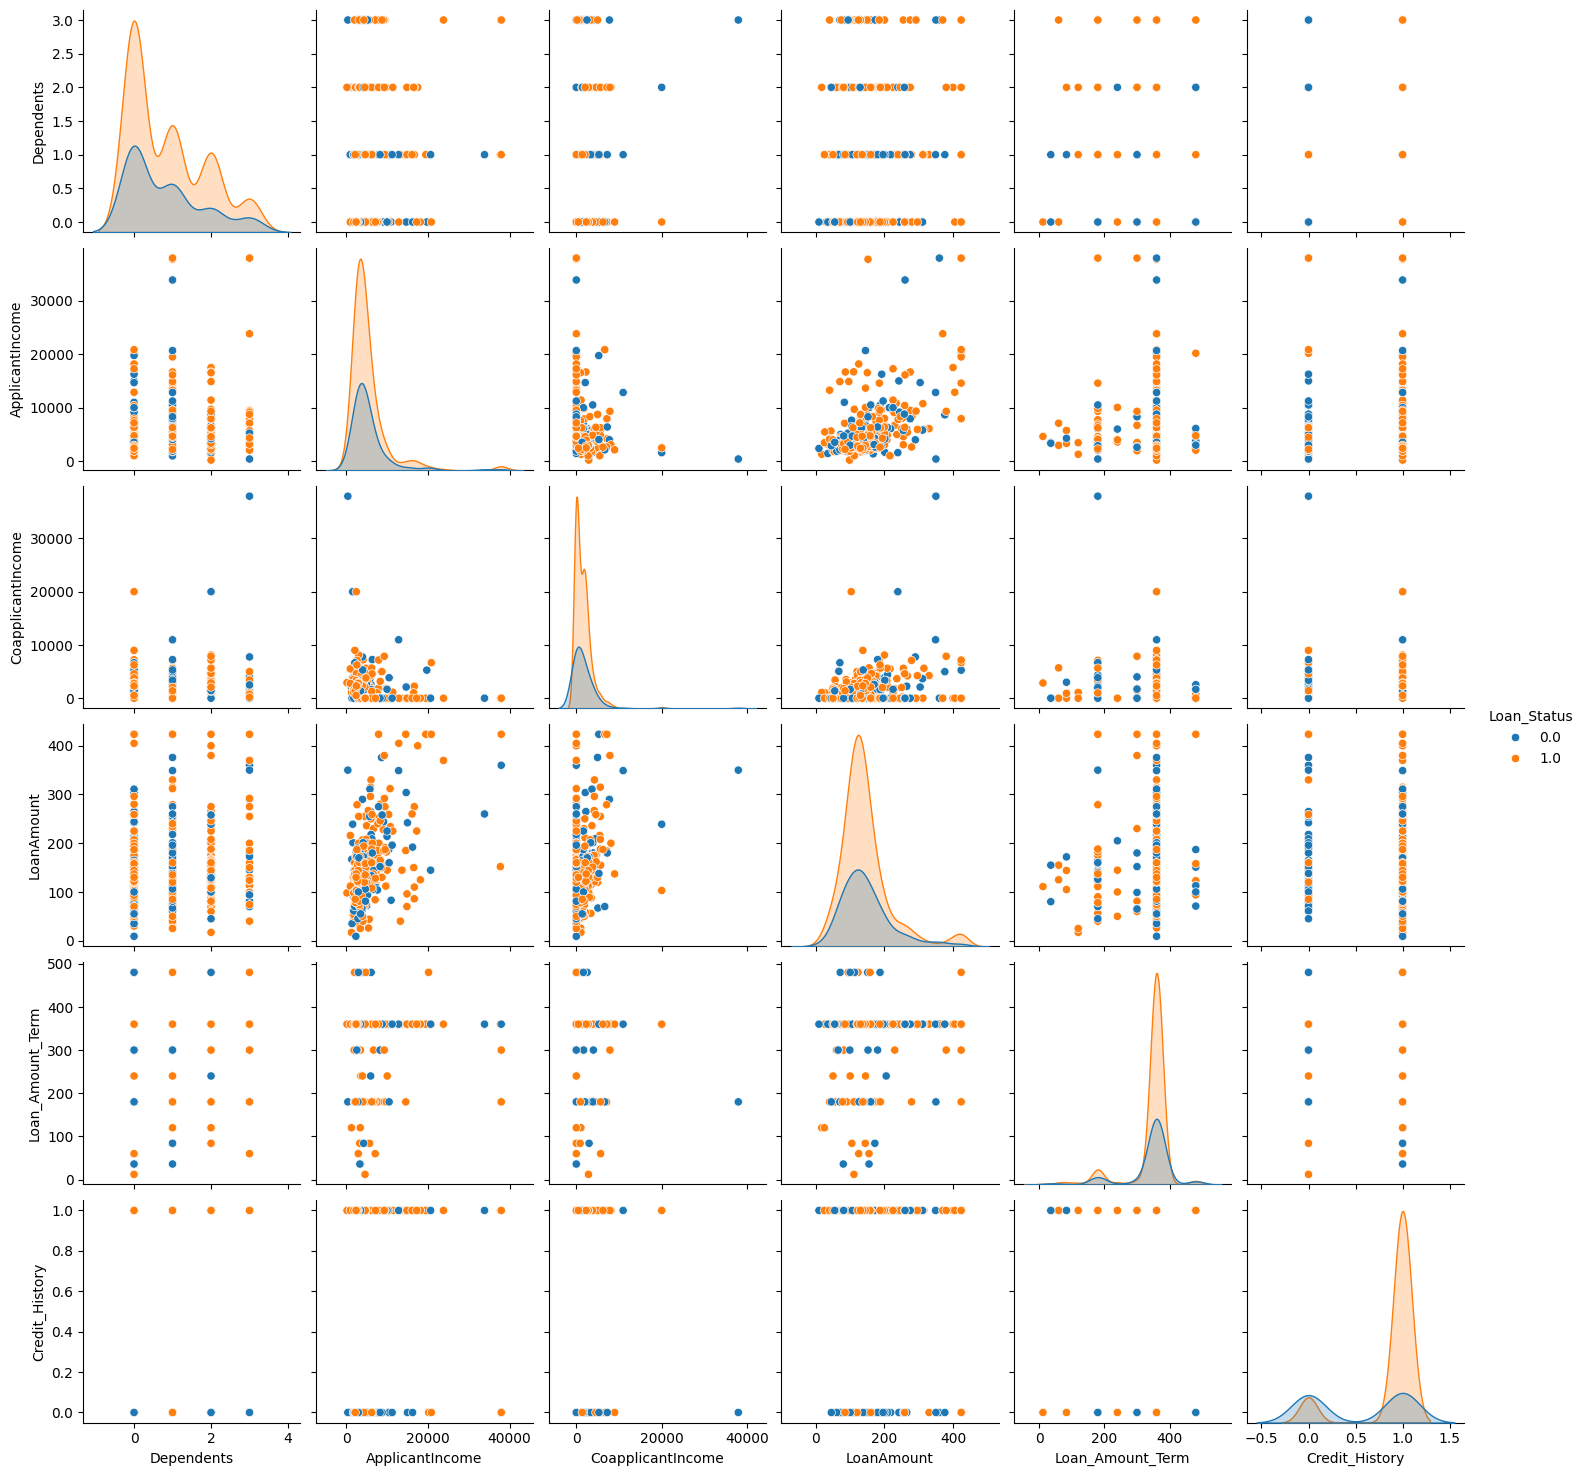

In [46]:
sns.pairplot(Train,hue='Loan_Status')
plt.show()

# interesting relationship in credit history
# income has a high effect on approval. 

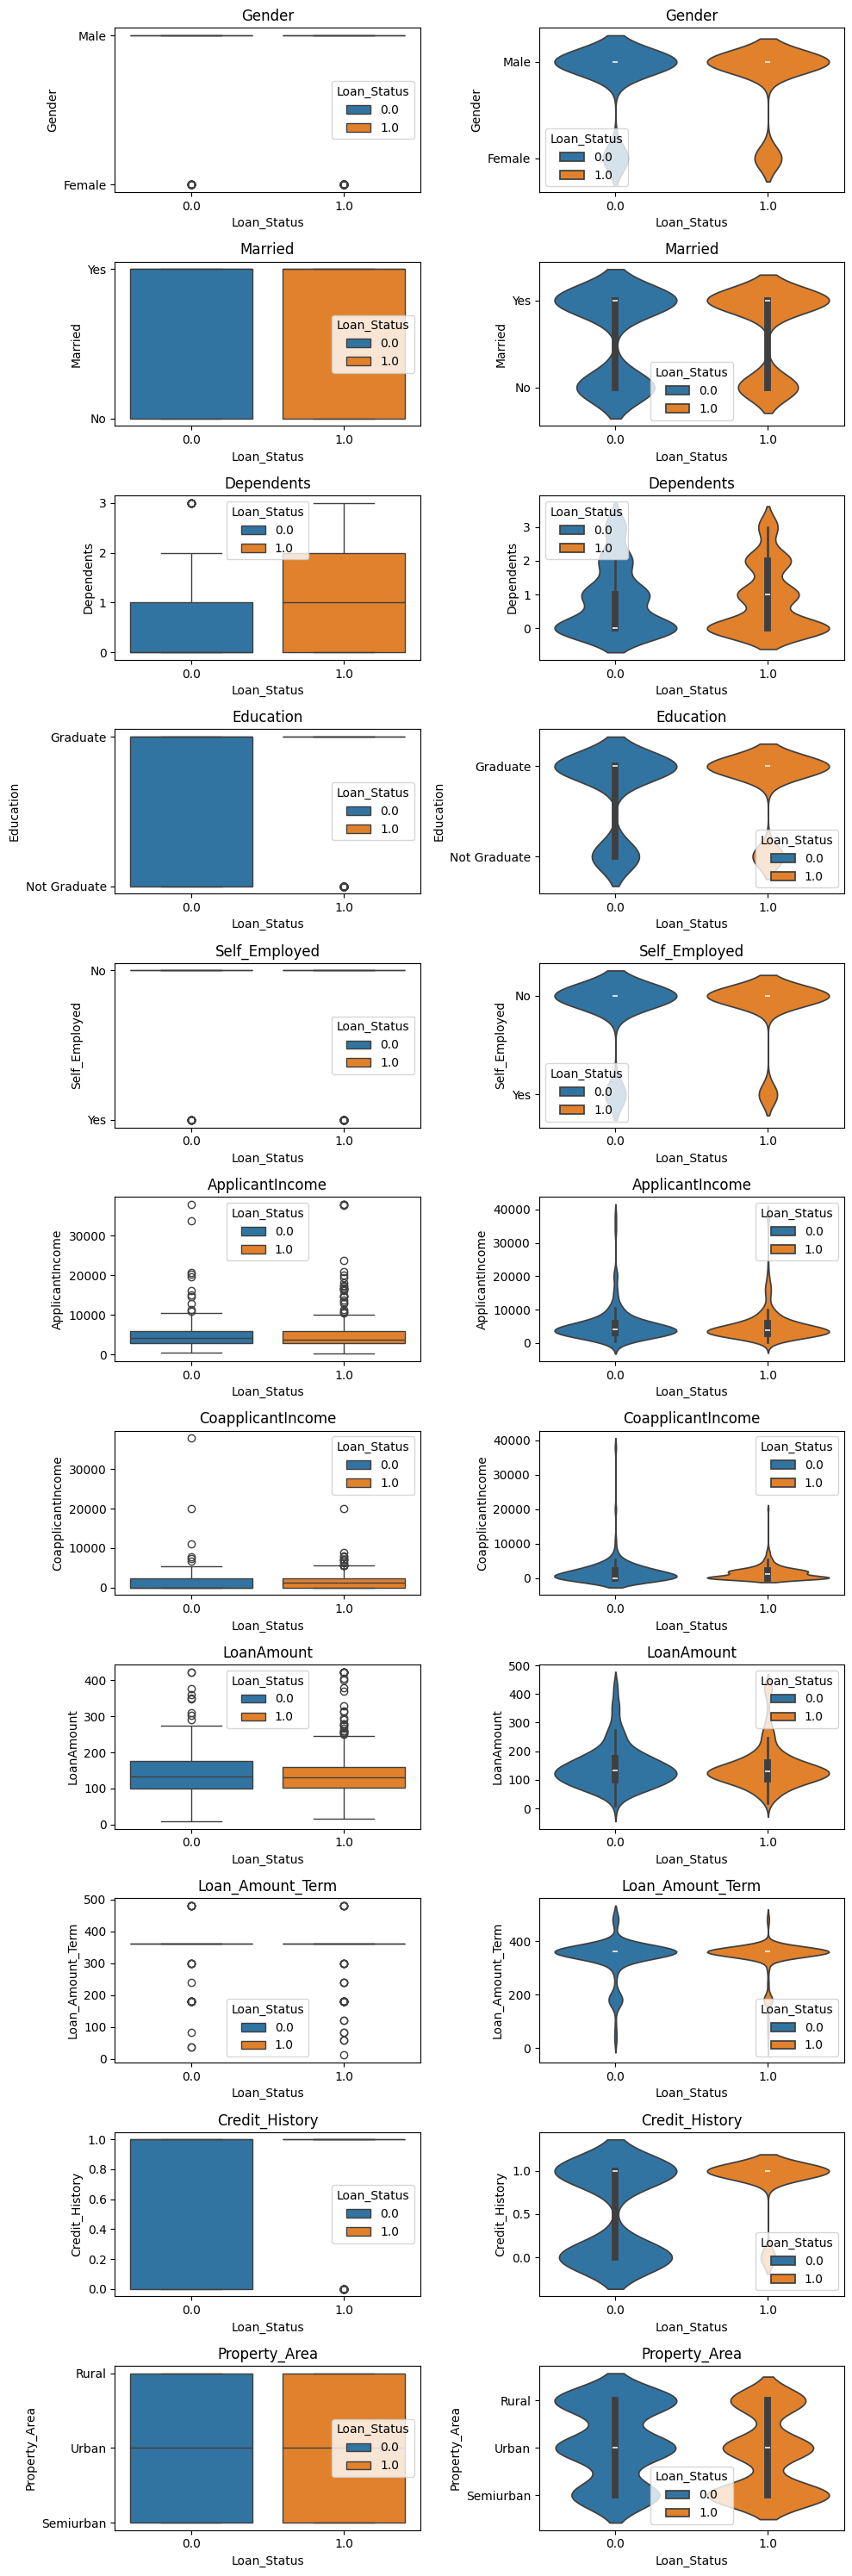

In [47]:
col=Train.columns.tolist()[:-1] #exclude the target variable. 


fig,ax = plt.subplots(nrows=len(col),ncols=2,figsize=(10,30))
for i,cols in enumerate(col):
    sns.violinplot(data=Train,x='Loan_Status',y=cols,orient='v',hue='Loan_Status',ax=ax[i,1])
    ax[i,1].set_title(cols)
    sns.boxplot(data=Train,x='Loan_Status',y=cols,orient='v',hue='Loan_Status',ax=ax[i,0])
    ax[i,0].set_title(cols)


plt.tight_layout()
plt.show()

# Conclusions
# Gender no difference to expect
# Married no difference to expect
# Dependents Slightly more apprvals when more dependents. 
# Education: Higher proportion of nongraduates in decline group. 
# Self employed no difference to expect
# ApplicantIncome no difference to expect. 
# Coapplicant Income. more accpted loans for higher income. No big difference
# LoanAmount: loan is easier accepted when smaller amount. 
# Loan_Amount_Term: no differnce to expect.
# Credit History: if credit history is 0, then higher change of decline. 
# Property area: SemiUrban seems to have highest approval rate. Rural the smallest

# Encoding

In [48]:
# for categorical variables
Categorical = Train.select_dtypes(exclude=np.number).columns.tolist()

ratios(Train[Categorical])

Missing  Ratio  Total    Type  UniqueVals
Gender               0    0.0    491  object           2
Married              0    0.0    491  object           2
Education            0    0.0    491  object           2
Self_Employed        0    0.0    491  object           2
Property_Area        0    0.0    491  object           3

In [49]:
# OneHotEncoding for all categorical variables
enc = OneHotEncoder(drop='first')
Train_enc = Train.copy()
Train_enc.reset_index(inplace=True,drop=True)
Test_enc = Test.copy()
Test_enc.reset_index(inplace=True,drop=True)

for col in Categorical:
    #Train
    Train_enc[col]=Train_enc[col].astype(str)
    encoded_data=enc.fit_transform(Train_enc[[col]])
    encoded_df = pd.DataFrame(encoded_data.toarray(), columns=enc.get_feature_names_out([col]))
    Train_enc = pd.concat([Train_enc, encoded_df], axis=1)
    #Test
    Test_enc[col]=Test_enc[col].astype(str)
    encoded_data=enc.transform(Test_enc[[col]])
    encoded_df = pd.DataFrame(encoded_data.toarray(), columns=enc.get_feature_names_out([col]))
    Test_enc = pd.concat([Test_enc, encoded_df], axis=1)


Train_enc.drop(columns=Categorical,inplace=True)
Test_enc.drop(columns=Categorical,inplace=True)

In [50]:
Train_enc['Loan_Status'].value_counts()

Loan_Status
1.0    337
0.0    154
Name: count, dtype: Int64

# Feature Engineering

In [51]:
# In a later stage there is already a plan to create a column with Feature engineering based on Applicant Income and CoapplicantIncome. 
# a count of the number of applicants. 
dataset=[Train_enc,Test_enc]
for df in dataset:
    df['NoApplicants']= df.apply(lambda row: 2 if row['CoapplicantIncome']>1 else 1,axis=1 ).astype('float64')['NoApplicants']= df.apply(lambda row: 2 if row['CoapplicantIncome']>1 else 1,axis=1 ).astype('float64')
    df['TotalIncome']=df['ApplicantIncome']+df['CoapplicantIncome']
    df['MonthlyFee']=df['LoanAmount']/df['Loan_Amount_Term']
    df['IncomeLoanRatio']=df['MonthlyFee']/Train_enc['TotalIncome']
    df['MonthlyIncomePerPerson'] = df['TotalIncome']/(df['Dependents']+1)
    df['IsAlone']= np.where((df['Dependents']==0),1,0)

## Bivariate analysis

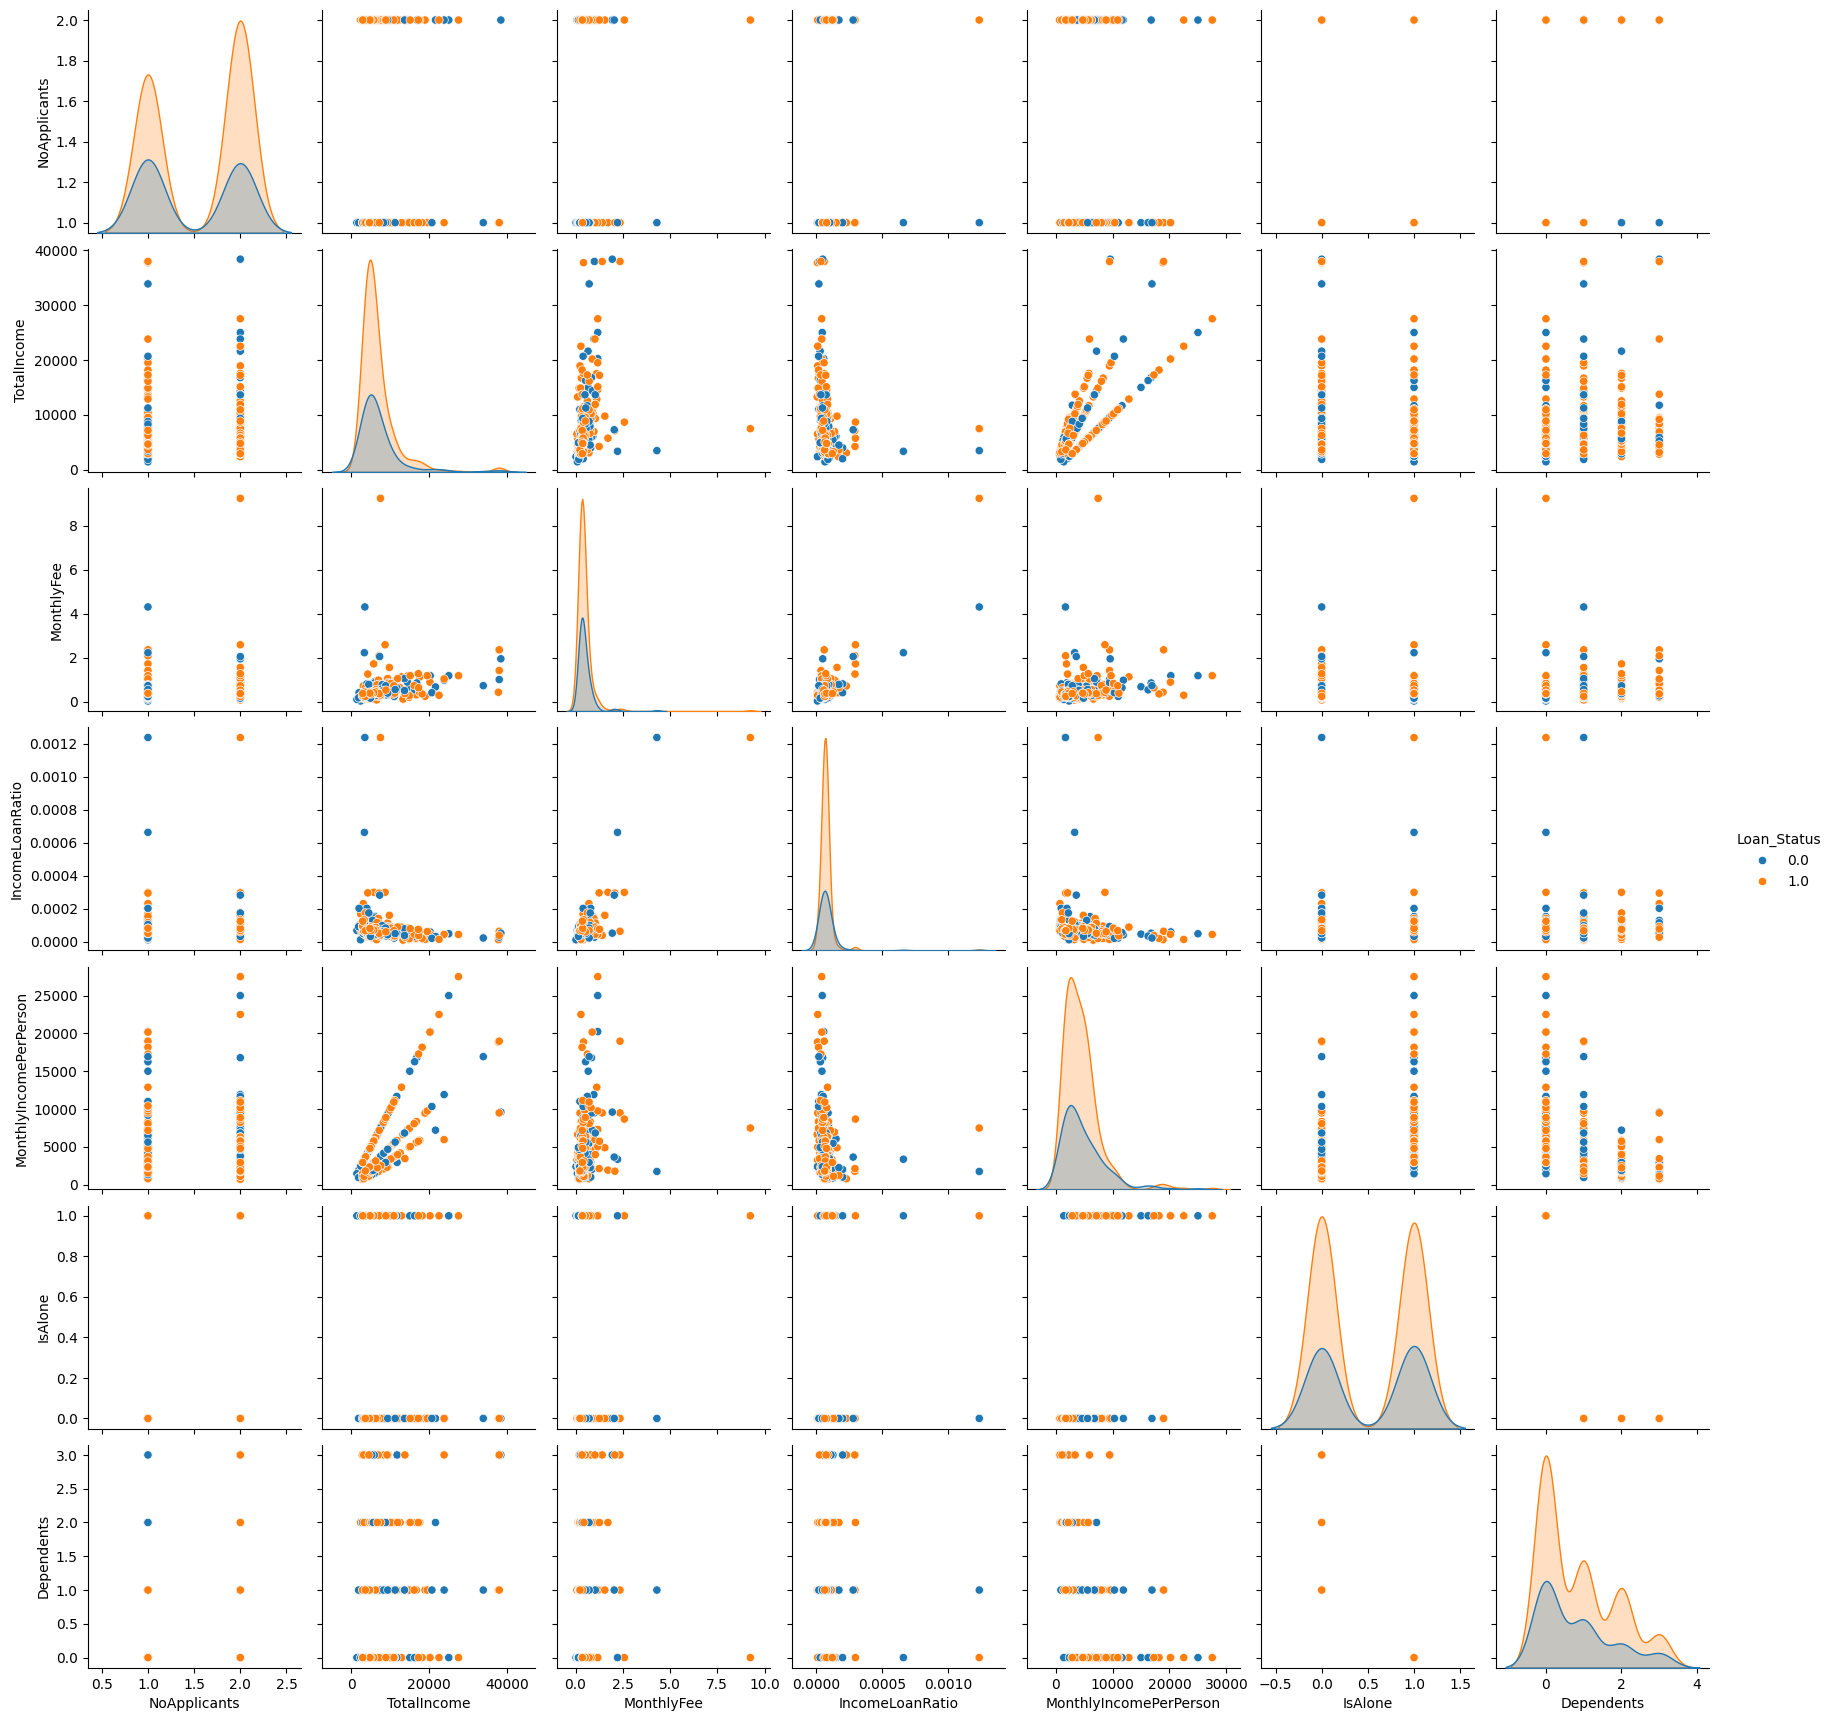

In [52]:
bivariate_cols = Train_enc.iloc[:, -6:]
bivariate_cols['Loan_Status'] = Train_enc['Loan_Status']
bivariate_cols['Dependents']=Train_enc['Dependents']
sns.pairplot(bivariate_cols,hue='Loan_Status')
plt.show()

# Note relation TotalIncome and MonthlyIncomePerPerson. There are 4 lines
# no further direct information.


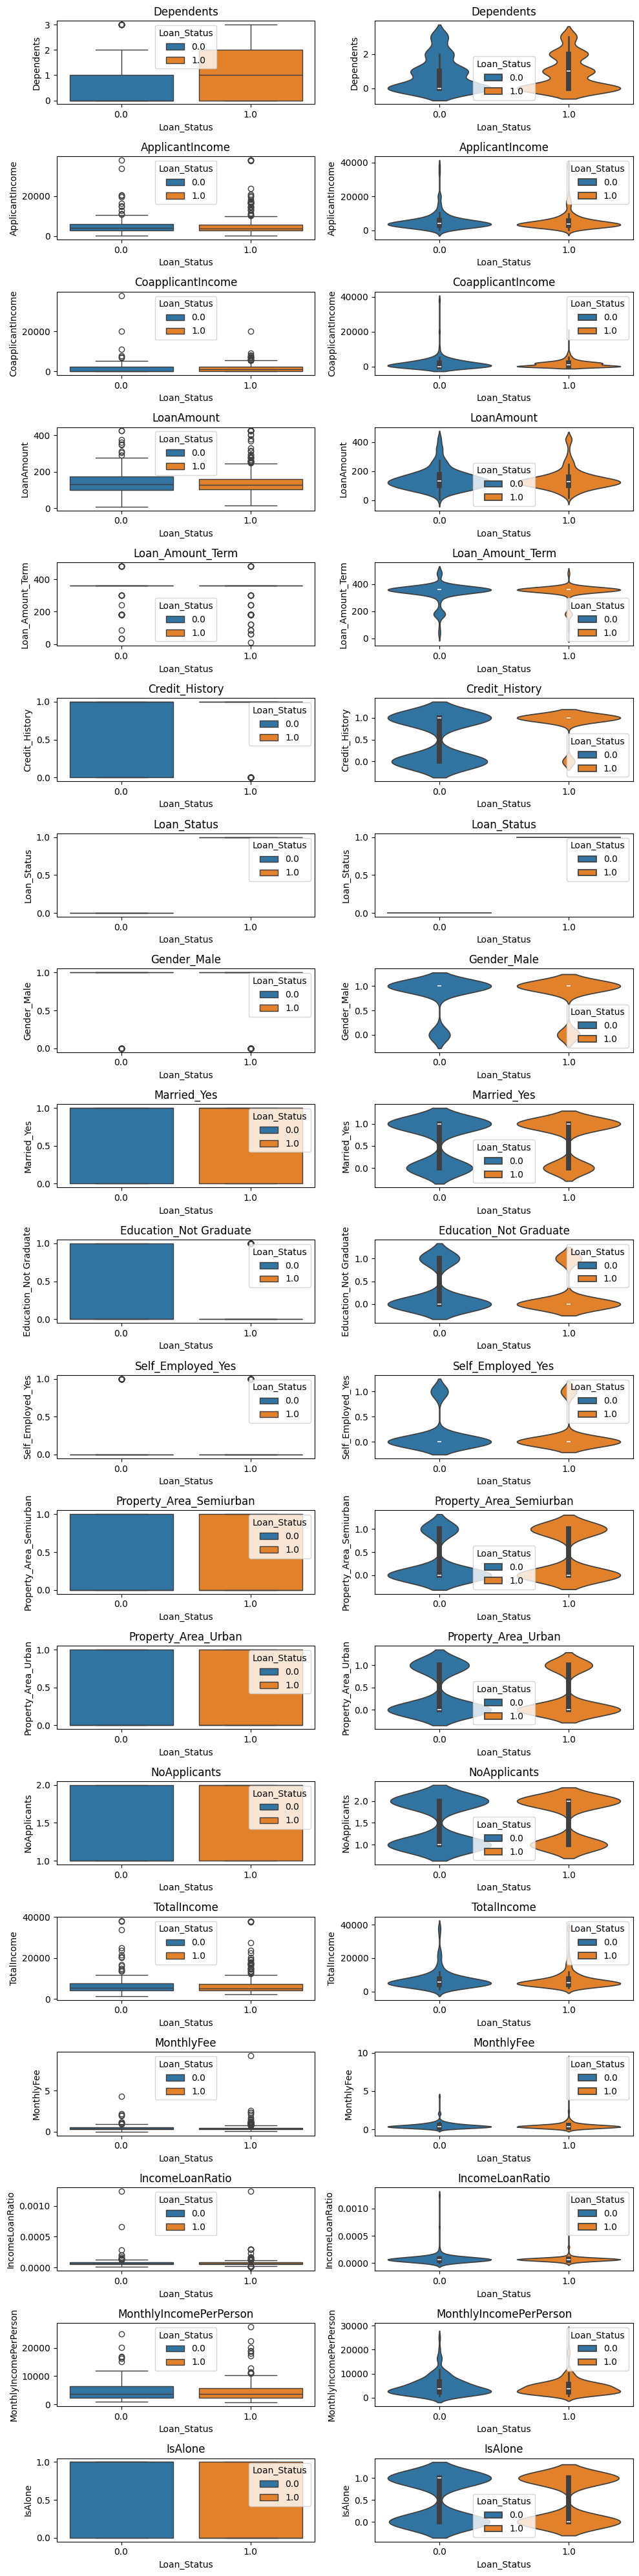

In [53]:
col=Train_enc.columns.tolist()


fig,ax = plt.subplots(nrows=len(col),ncols=2,figsize=(10,40))
for i,cols in enumerate(col):
    sns.violinplot(data=Train_enc,x='Loan_Status',y=cols,orient='v',hue='Loan_Status',ax=ax[i,1])
    ax[i,1].set_title(cols)
    sns.boxplot(data=Train_enc,x='Loan_Status',y=cols,orient='v',hue='Loan_Status',ax=ax[i,0])
    ax[i,0].set_title(cols)


plt.tight_layout()
plt.show()

Number of values: 491


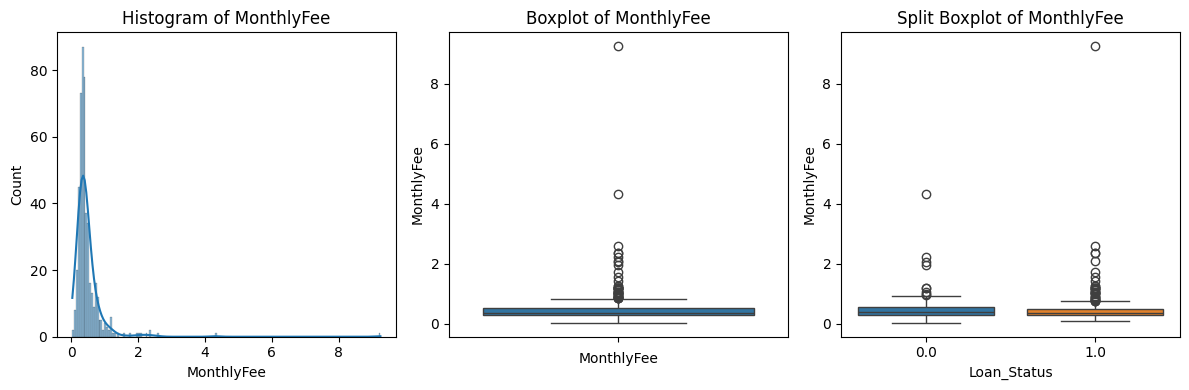

Number of missing values: 0
count    491.000000
mean       0.478506
std        0.535706
min        0.025000
25%        0.288889
50%        0.369444
75%        0.511111
max        9.250000
Name: MonthlyFee, dtype: float64


In [54]:
# doublecheck outlier in MonthlyFee and IncomeLoanRatio
quant_analysis(Train_enc,'MonthlyFee')
MonthlyFeeMean=Train_enc['MonthlyFee'].mean()

Train_enc.loc[Train_enc['MonthlyFee']>2.235333,'MonthlyFee']=MonthlyFeeMean
Test_enc.loc[Test_enc['MonthlyFee']>2.235333,'MonthlyFee']=MonthlyFeeMean

Number of values: 491


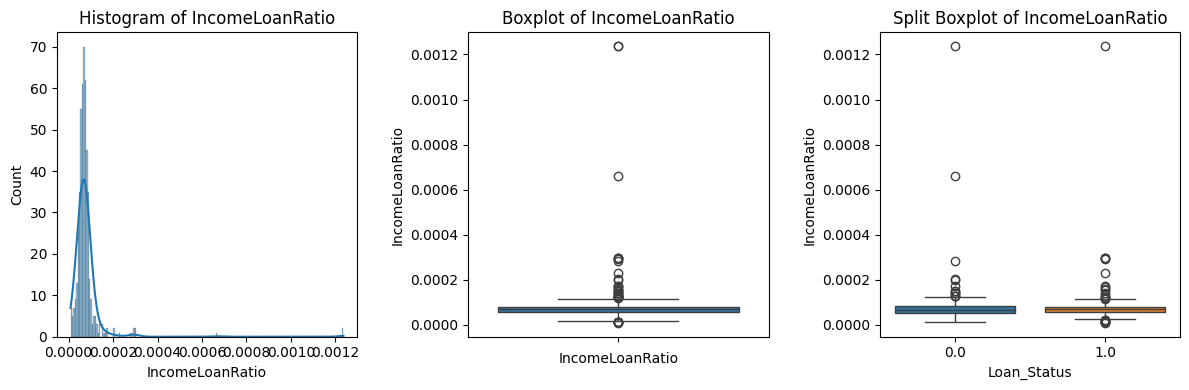

Number of missing values: 0
count    491.000000
mean       0.000078
std        0.000086
min        0.000008
25%        0.000056
50%        0.000069
75%        0.000081
max        0.001237
Name: IncomeLoanRatio, dtype: float64


In [55]:
quant_analysis(Train_enc,'IncomeLoanRatio')
IncomeLoanRatioMean=Train_enc['IncomeLoanRatio'].mean()

Train_enc.loc[Train_enc['IncomeLoanRatio']>0.000295,'IncomeLoanRatio']=IncomeLoanRatioMean
Test_enc.loc[Test_enc['IncomeLoanRatio']>0.000295,'IncomeLoanRatio']=IncomeLoanRatioMean

# Data Preparation

## Balancing (SMOTE)

In [56]:
# Method to choose is Smote, there is an imbalanced dataset and SMOTE is preferred compared to upsampling or downsampling. 
# Balancing is only performed on the training set. 

df_train = Train_enc.drop(columns=['Loan_Status'],axis=1)
y_train = Train_enc['Loan_Status']
df_test = Test_enc.drop(columns=['Loan_Status'],axis=1)
y_test = Test_enc['Loan_Status']


Train_enc['Loan_Status'].value_counts()
smote = SMOTE(sampling_strategy = 'auto',k_neighbors = 5,random_state=42)

X_Balanced,y_balanced=smote.fit_resample(df_train,y_train)


In  this case i use 2 different scalers to check the performance. probably logictic regression perfers the BoxCox. 

## Scaling BoxCox

In [57]:
def SkewMeasure(df):
    nonObjectColList = df.dtypes[df.dtypes != 'object'].index
    skewM = df[nonObjectColList].apply(lambda x: round(skew(x),2)).sort_values(ascending = False)
    skewM=pd.DataFrame({'skew':skewM})
    return skewM

In [58]:
# yeo-johnson is an alternative method. In this case boxcox can be used since we only have positive values. 
skew1 = SkewMeasure(X_Balanced)
X_Balanced_boxcox=X_Balanced.copy()
X_test_boxcox=df_test.copy()


for i in skew1.index:
    X_Balanced_boxcox[i] = special.boxcox1p(X_Balanced[i],0.15) #lambda = 0.15
    X_test_boxcox[i]  = special.boxcox1p(df_test[i],0.15) #lambda = 0.15
skew2=SkewMeasure(X_Balanced_boxcox)

pd.concat((skew1,skew2),axis=1)
# data is more normalized now. # note that Loan_Amount_Term is worse. For now we keep this. 

skew  skew
CoapplicantIncome        6.74 -0.04
ApplicantIncome          3.91  1.07
TotalIncome              3.46  1.20
MonthlyFee               2.98  2.00
IncomeLoanRatio          2.75  2.75
MonthlyIncomePerPerson   2.33  0.32
Self_Employed_Yes        2.04  2.00
LoanAmount               1.73 -0.10
Education_Not Graduate   1.23  1.19
Dependents               0.86  0.47
Property_Area_Urban      0.71  0.68
Property_Area_Semiurban  0.67  0.64
IsAlone                  0.00 -0.00
NoApplicants            -0.14 -0.14
Married_Yes             -0.60 -0.61
Credit_History          -0.83 -0.87
Gender_Male             -1.77 -1.81
Loan_Amount_Term        -2.48 -4.30

## StandardScaler


In [108]:
scaler = StandardScaler().fit(X_Balanced)
X_Balanced_scaled=scaler.transform(X_Balanced)
X_Test_scaled=scaler.transform(df_test)
X_Balanced_scaled = pd.DataFrame(X_Balanced_scaled, columns = X_Balanced.columns)
X_Test_scaled = pd.DataFrame(X_Test_scaled, columns = df_test.columns)

## Feature elimination

In [60]:
# RFE technicque is used in combination with regression forrest. 
# Im still searching for the best moment to conduct this analyis, together with which model to apply for it. 
# in this case RFC is used, however no hyperparameter tuning, and is the list of features also valid for other classifiers? 

rfe_f1_score_list = []

RFC = RandomForestClassifier(max_depth=5, random_state=42)

for k in range(1, X_Balanced_scaled.shape[1]):
    RFE_selector = RFE(estimator=RFC, n_features_to_select=k, step=1) 
    RFE_selector.fit(X_Balanced_scaled, y_balanced)
    
    sel_X_train = RFE_selector.transform(X_Balanced_scaled)
    sel_X_test = RFE_selector.transform(X_Test_scaled)
    
    RFC.fit(sel_X_train, y_balanced)
    RFE_preds = RFC.predict(sel_X_test)
    
    f1_score_rfe = round(f1_score(y_test, RFE_preds, average='weighted'), 3)

    rfe_f1_score_list.append(f1_score_rfe)


# after running code above we know what the ideal number of features is. 
# in this case 9 features are chosen instead of 2 because we have more models to apply. 2 is ideal for RFC, maybe not for others. 
RFE_selector = RFE(estimator=RFC, n_features_to_select=9, step=1)
RFE_selector.fit(X_Balanced_scaled, y_balanced)
selected_features_mask = RFE_selector.get_support()
selected_features = X_Balanced_scaled.columns[selected_features_mask]
selected_features


Index(['ApplicantIncome', 'LoanAmount', 'Credit_History',
       'Education_Not Graduate', 'Property_Area_Semiurban', 'TotalIncome',
       'MonthlyFee', 'IncomeLoanRatio', 'MonthlyIncomePerPerson'],
      dtype='object')

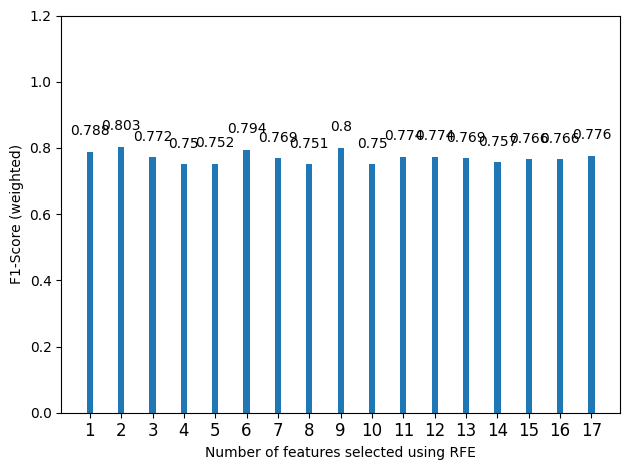

In [61]:
fig, ax = plt.subplots()

x = np.arange(1, X_Balanced_scaled.shape[1])
y = rfe_f1_score_list

ax.bar(x, y, width=0.2)
ax.set_xlabel('Number of features selected using RFE')
ax.set_ylabel('F1-Score (weighted)')
ax.set_ylim(0, 1.2)
ax.set_xticks(np.arange(1, X_Balanced_scaled.shape[1]))
ax.set_xticklabels(np.arange(1, X_Balanced_scaled.shape[1]), fontsize=12)

for i, v in enumerate(y):
    plt.text(x=i+1, y=v+0.05, s=str(v), ha='center')
    
plt.tight_layout()

## Summary Datasets

In [156]:
X_Balanced_boxcox2=X_Balanced_boxcox[selected_features]
X_test_boxcox2=X_test_boxcox[selected_features]

X_Balanced_scaled2=X_Balanced_scaled[selected_features]
X_Test_scaled2=X_Test_scaled[selected_features]


# Boxcox data: 
# X_Balanced_boxcox         with        y_balanced
# X_test_boxcox             with        y_test


# Standardscaler data: 
# X_Balanced_scaled         with        y_balanced
# X_Test_scaled             with        y_test

# Modelling

## Neural Network

In [63]:
# custom metrics since Keras does not offer these functions. 
# Accuracy and loss function are already possible be default in keras. 
# in this case we compare based on Precision and Recall
def precision(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def recall(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [64]:
# This is the first time i apply Neural network, so most code is copied. 
# However good exercise to learn more, and apply in the future. 

def fit_model(data, labels, test_data,test_label, epochs, batch_size):
    
    n_inputs = data.shape[1]
    model    = keras.Sequential()
    model.add(layers.Dense(16, activation ='relu', input_shape =(n_inputs, )))
    model.add(layers.Dropout(0.15))
    model.add(layers.Dense(32,activation = 'relu'))
    model.add(layers.Dropout(0.15))
    model.add(layers.Dense(1,activation ='sigmoid'))  # sigmoid for last node since we have a binary target.
    
    model_file_name = 'MLP_predict_default_case_study.hdf5'
    ckpt = ModelCheckpoint(model_file_name, monitor='val_precision',
                           save_best_only=True, mode='max')
    early = EarlyStopping(monitor="val_recall", mode="max", patience=30)

    model.compile(optimizer = 'adam',
                 loss= 'binary_crossentropy',
                 metrics = [precision,recall])
    
    history = model.fit(data,
                       labels,
                       epochs=epochs,
                       batch_size=batch_size,
                       callbacks=[ckpt, early],
                       validation_data=(test_data,test_label))
    
    return model

In [65]:
def compute_precisions_thresolds(data, labels, test_data, test_label, epochs, batch_size):
    global trained_model
    trained_model = fit_model(data, labels, test_data, test_label, epochs=epochs, batch_size=batch_size)
    y_test_pred   = trained_model.predict(test_data)
    
    P_weighted = [] ; P_binary = [];  R_weighted = [] ;R_binary = []; F1_weighted = [] ;F1_binary = []; cut_off = [] ; metrics = pd.DataFrame()
    threshold_list = [0.25,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.96]
    for thres in threshold_list:
        cut_off.append(thres)
        y_test_pred_new = [1 if el>thres else 0 for el in y_test_pred]
        
        prec_weighted            = round(precision_score(test_label, y_test_pred_new, pos_label=1, average='weighted'),2)
        P_weighted.append(prec_weighted)

        prec_binary            = round(precision_score(test_label, y_test_pred_new, pos_label=1, average='binary'),2)
        P_binary.append(prec_binary)

        rec_weighted             = round(recall_score(test_label, y_test_pred_new, pos_label=1,average='weighted'),2)
        R_weighted.append(rec_weighted)

        rec_binary             = round(recall_score(test_label, y_test_pred_new, pos_label=1,average='binary'),2)
        R_binary.append(rec_binary)

        f1_weighted              = round(f1_score(test_label, y_test_pred_new, average='weighted'),2)
        F1_weighted.append(f1_weighted)

        f1_binary              = round(f1_score(test_label, y_test_pred_new, average='binary'),2)
        F1_binary.append(f1_binary)
        
    metrics = pd.DataFrame({'Threshold' : cut_off, 'Precision weighted' : P_weighted, 'Precision binary' : P_binary,'Recall weighted' : R_weighted, 'Recall binary' : R_binary,'F1 Score weighted' : F1_weighted, 'F1 Score binary' : F1_binary})
    return metrics.sort_values(by=['Threshold'], ascending=False)

Epoch 1/250


7/7 [==============================] - 2s 99ms/step - loss: 3.5993 - precision: 0.4970 - recall: 0.9519 - val_loss: 1.7109 - val_precision: 0.6761 - val_recall: 1.0000
Epoch 2/250
7/7 [==============================] - 0s 23ms/step - loss: 2.3950 - precision: 0.4949 - recall: 0.8714 - val_loss: 0.9925 - val_precision: 0.6761 - val_recall: 1.0000
Epoch 3/250
7/7 [==============================] - 0s 19ms/step - loss: 1.5424 - precision: 0.5240 - recall: 0.7621 - val_loss: 0.6659 - val_precision: 0.6803 - val_recall: 0.9857
Epoch 4/250
7/7 [==============================] - 0s 9ms/step - loss: 1.2545 - precision: 0.4965 - recall: 0.5278 - val_loss: 0.8645 - val_precision: 0.3000 - val_recall: 0.0429
Epoch 5/250
7/7 [==============================] - 0s 9ms/step - loss: 1.3293 - precision: 0.4874 - recall: 0.3438 - val_loss: 0.9389 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/250
7/7 [==============================] - 0s 9ms/step - loss: 1.2544 - precision: 0.4622 - recall

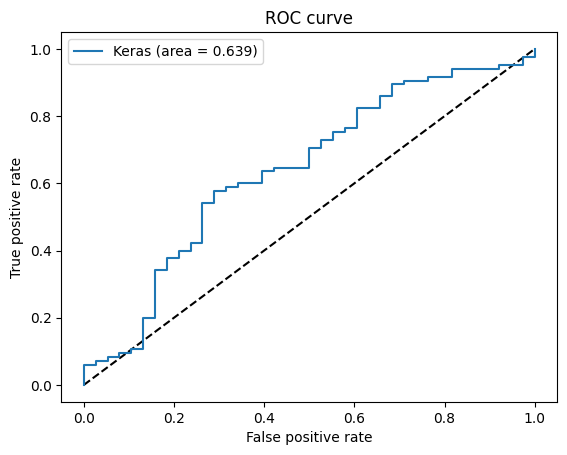

   Threshold  Precision weighted  Precision binary  Recall weighted  \
9       0.96                0.10              0.00             0.31   
8       0.95                0.10              0.00             0.31   
7       0.90                0.10              0.00             0.31   
6       0.80                0.10              0.00             0.31   
5       0.70                0.10              0.00             0.31   
4       0.60                0.10              0.00             0.31   
3       0.50                0.65              0.74             0.65   
2       0.40                0.48              0.69             0.69   
1       0.30                0.48              0.69             0.69   
0       0.25                0.48              0.69             0.69   

   Recall binary  F1 Score weighted  F1 Score binary  
9           0.00               0.15             0.00  
8           0.00               0.15             0.00  
7           0.00               0.15             0.00 

In [66]:
# execute for boxcox
box_cox_metrics = compute_precisions_thresolds(X_Balanced_boxcox, y_balanced, X_test_boxcox, y_test,epochs=250, batch_size=100)



y_pred_keras = trained_model.predict(X_test_boxcox).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

print(box_cox_metrics)

Epoch 1/250


7/7 [==============================] - 1s 37ms/step - loss: 0.7062 - precision: 0.5326 - recall: 0.7730 - val_loss: 0.6372 - val_precision: 0.6982 - val_recall: 0.7857
Epoch 2/250
7/7 [==============================] - 0s 11ms/step - loss: 0.6894 - precision: 0.5618 - recall: 0.6923 - val_loss: 0.6357 - val_precision: 0.7246 - val_recall: 0.7857
Epoch 3/250
7/7 [==============================] - 0s 10ms/step - loss: 0.6621 - precision: 0.5903 - recall: 0.6913 - val_loss: 0.6319 - val_precision: 0.8206 - val_recall: 0.7786
Epoch 4/250
7/7 [==============================] - 0s 11ms/step - loss: 0.6606 - precision: 0.5871 - recall: 0.6943 - val_loss: 0.6260 - val_precision: 0.8638 - val_recall: 0.7381
Epoch 5/250
7/7 [==============================] - 0s 8ms/step - loss: 0.6447 - precision: 0.6247 - recall: 0.6980 - val_loss: 0.6210 - val_precision: 0.8553 - val_recall: 0.6905
Epoch 6/250
7/7 [==============================] - 0s 8ms/step - loss: 0.6245 - precision: 0.6420 - recall: 0.717

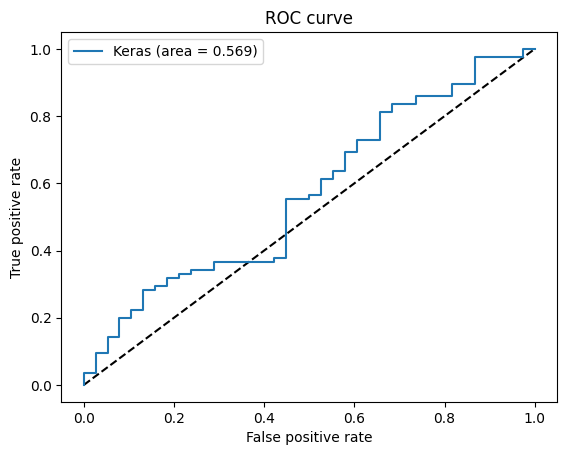

   Threshold  Precision weighted  Precision binary  Recall weighted  \
9       0.96                0.10              0.00             0.31   
8       0.95                0.10              0.00             0.31   
7       0.90                0.79              1.00             0.37   
6       0.80                0.72              0.88             0.47   
5       0.70                0.74              0.88             0.60   
4       0.60                0.78              0.89             0.72   
3       0.50                0.77              0.85             0.76   
2       0.40                0.77              0.82             0.77   
1       0.30                0.76              0.81             0.77   
0       0.25                0.76              0.79             0.77   

   Recall binary  F1 Score weighted  F1 Score binary  
9           0.00               0.15             0.00  
8           0.00               0.15             0.00  
7           0.09               0.27             0.17 

In [67]:
# execute for scaled
stand_scaler_metrics = compute_precisions_thresolds(X_Balanced_scaled, y_balanced, X_Test_scaled, y_test,epochs=250, batch_size=100)
stand_scaler_metrics


y_pred_keras = trained_model.predict(X_test_boxcox).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

print(stand_scaler_metrics)

In [68]:
# Neural network does not show any promise at the moment. Maybe treshold 0,5 for scaled data. 

## Various Models

In [69]:
#compare binary with weighted: binary, overal. Weigthed for giving higher weight to minority class. 

def cal_score(y_test, y_pred): 
    cm              = confusion_matrix(y_test, y_pred)
    prec_scr_weighted  = precision_score(y_test, y_pred, average='weighted')*100
    prec_scr_binary  = precision_score(y_test, y_pred, average='binary')*100
    rec_scr_weighted   = recall_score(y_test ,y_pred, average='weighted')*100
    rec_scr_binary    = recall_score(y_test ,y_pred, average='binary')*100
    f1_scr_weighted    = f1_score(y_test, y_pred, average='weighted')*100 
    f1_scr_binary     = f1_score(y_test, y_pred, average='binary')*100 
    return prec_scr_weighted, prec_scr_binary, rec_scr_weighted, rec_scr_binary, f1_scr_weighted, f1_scr_binary, cm

In [70]:
def metrics_calculation(classifier, training_data, testing_data, training_label, testing_label):
    
    result = []
    cols = ['Mean Accuracy', 'Accuracy deviation', 'Precision Weighted', 'Precision Binary', 'Recall Weighted','Recall Binary', 'F1 Score Weighted', 'F1 Score Binary', 'Confusion Matrix']
    
    crs_val     = cross_val_score(classifier, training_data, training_label, cv=5)
    mean_acc = round(np.mean(crs_val),3)
    std_acc  = round(np.std(crs_val),3)
    classifier.fit(training_data, training_label)
    predictions = classifier.predict(testing_data)
    prec_scr_weighted, prec_scr_binary, rec_scr_weighted, rec_scr_binary, f1_scr_weighted, f1_scr_binary, cm = cal_score(testing_label, predictions)
    result.extend([mean_acc,std_acc, prec_scr_weighted, prec_scr_binary, rec_scr_weighted, rec_scr_binary, f1_scr_weighted, f1_scr_binary, cm])
    series_result = pd.Series(data=result, index=cols)
    tn,fp,fn,tp=cm.ravel()
    return series_result


In [71]:
clf_dict = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'Logistic Regression' : LogisticRegression(random_state=42),
    'Light GBM' : LGBMClassifier(random_state=42)
}

In [72]:
# Boxcox data

frame = {}
for key in clf_dict:

    classifier_result = metrics_calculation(clf_dict[key], X_Balanced_boxcox2, X_test_boxcox2, y_balanced, y_test)
    frame[key]    = classifier_result
        
box_cox_smote_df = pd.DataFrame(frame)
box_cox_smote_df

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 269, number of negative: 270
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1160
[LightGBM] [Info] Number of data points in the train set: 539, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499072 -> initscore=-0.003711
[LightGBM] [Info] Start training from score -0.003711
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

Random Forest               XGBoost  \
Mean Accuracy                      0.815                 0.798   
Accuracy deviation                 0.088                 0.096   
Precision Weighted             73.226653             72.775982   
Precision Binary               81.481481             80.722892   
Recall Weighted                72.357724             72.357724   
Recall Binary                  77.647059             78.823529   
F1 Score Weighted              72.715741             72.547574   
F1 Score Binary                79.518072             79.761905   
Confusion Matrix    [[23, 15], [19, 66]]  [[22, 16], [18, 67]]   

                     Logistic Regression             Light GBM  
Mean Accuracy                      0.714                 0.779  
Accuracy deviation                 0.031                   0.1  
Precision Weighted             76.470227             75.391632  
Precision Binary               81.318681             82.926829  
Recall Weighted                77.235772             74.796748  
Recall Binary                  87.058824                  80.0  
F1 Score Weighted              76.648189             75.048914  
F1 Score Binary                84.090909             81.437126  
Confusion Matrix    [[21, 17], [11, 74]]  [[24, 14], [17, 68]]

In [73]:
# Standardscaler data

frame = {}
for key in clf_dict:

    classifier_result = metrics_calculation(clf_dict[key], X_Balanced_scaled, X_Test_scaled, y_balanced, y_test)
    frame[key]    = classifier_result
        
box_cox_smote_df = pd.DataFrame(frame)
box_cox_smote_df

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 269, number of negative: 270
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1380
[LightGBM] [Info] Number of data points in the train set: 539, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499072 -> initscore=-0.003711
[LightGBM] [Info] Start training from score -0.003711
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

Random Forest               XGBoost  \
Mean Accuracy                      0.816                 0.789   
Accuracy deviation                 0.096                 0.112   
Precision Weighted             75.985895             76.324091   
Precision Binary                83.13253             84.615385   
Recall Weighted                75.609756             74.796748   
Recall Binary                  81.176471             77.647059   
F1 Score Weighted              75.777272             75.318362   
F1 Score Binary                82.142857             80.981595   
Confusion Matrix    [[24, 14], [16, 69]]  [[26, 12], [19, 66]]   

                     Logistic Regression             Light GBM  
Mean Accuracy                       0.73                 0.797  
Accuracy deviation                 0.041                 0.108  
Precision Weighted             79.195808             75.837824  
Precision Binary               85.542169                 83.75  
Recall Weighted                78.861789             74.796748  
Recall Binary                  83.529412             78.823529  
F1 Score Weighted              79.006969             75.192759  
F1 Score Binary                 84.52381             81.212121  
Confusion Matrix    [[26, 12], [14, 71]]  [[25, 13], [18, 67]]

Standardscaler seems to perform better. from now on standardscaler data. 

## ROC

In [173]:
models = [{'label': 'Random Forest','model': RandomForestClassifier(random_state=42)},
    {'label' : 'XGBoost','model' : XGBClassifier(random_state=42)},
    {'label' : 'Logistic Regression','model' : LogisticRegression(random_state=42)},
    {'label' : 'Light GBM','model' : LGBMClassifier(random_state=42)}]

In [174]:
def plot_multiplt_rocauc(models,train_X, train_y ,dev_X, dev_y):
    
    for m in models:
        model = m['model']   
        model.fit(train_X, train_y)
        y_pred = model.predict(dev_X)
        pred   = model.predict_proba(dev_X)
        pred_new = [i[1] for i in pred]
        fpr, tpr, thresholds = roc_curve(dev_y, pred_new)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], roc_auc))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-Specificity(False Positive Rate)')
    plt.ylabel('Sensitivity(True Positive Rate)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()   # Display
    
    return 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 337, number of negative: 337
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1438
[LightGBM] [Info] Number of data points in the train set: 674, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

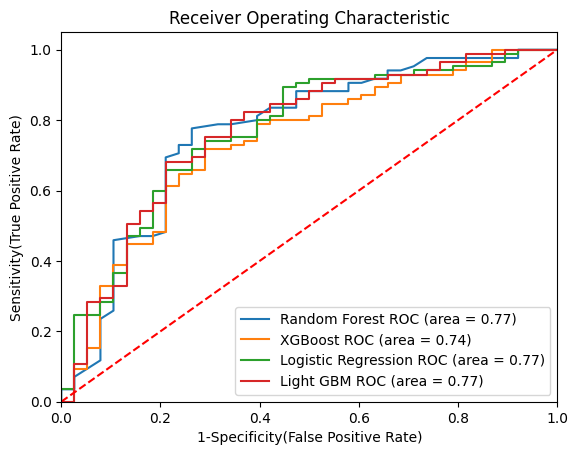

In [175]:
# Boxcox
plot_multiplt_rocauc(models,X_Balanced_scaled2,y_balanced, X_Test_scaled2, y_test)

## Hyperparameter Tuning

### Tuning

In [77]:
def hyperparameter_tuning(classifier, training_dataset, test_dataset, training_label, test_label):
    
    result = []
    cols = ['Precision', 'Recall', 'F1 Score', 'Confusion Matrix']
    
    model_name = {}
    class_str = str(classifier)
    if 'Random' in class_str:
        param_grid={
    "n_estimators":[27,36,100,200],
    "max_depth":[5,7,9,15],
    "min_samples_leaf":[2,4,6,8]
        }
        model = GridSearchCV(classifier, param_grid = param_grid, cv=StratifiedKFold(5))
        model.fit(training_dataset, training_label)
        best_est_model = model.best_estimator_
        model_name[class_str] = best_est_model
        best_est_model.fit(training_dataset, training_label)
        y_pred = best_est_model.predict(test_dataset)

    elif 'XG' in class_str:
        model_name = {}
        parameters = {
    'n_estimators': [100, 200], 
  'max_depth': [3, 5, 8], 
  'gamma' : [0.25,0.5,1],
  'reg_alpha': [0.1, 0.25, 0.5],
  'scale_pos_weight' : [8,10,12,15]
    }
        model = GridSearchCV(classifier, parameters, scoring="neg_log_loss", cv = StratifiedKFold(5), n_jobs = -1, verbose = 2)
        
        model.fit(training_dataset, training_label)
        best_est_model = model.best_estimator_
        model_name[class_str] = best_est_model
        best_est_model.fit(training_dataset, training_label)
        y_pred = best_est_model.predict(test_dataset)
        
    else:
        model_name = {}
        param_grid = {'n_estimators': [100,250,400],
          'min_split_gain' : [0.25,0.45,0.7],
         'max_depth': [4,7,10],
         'subsample': [0.65,0.85],
         'colsample_bytree': [0.45,0.65,0.85],
         'reg_lambda': [0.5,1,3,5],
         'num_leaves' : [30,50,70],
         'min_data_in_leaf' : [100,400,600]
         }
        
        model = GridSearchCV(estimator = classifier, param_grid = param_grid, 
                          cv = StratifiedKFold(5), n_jobs = -1, verbose = 2)
        
        model.fit(training_dataset, training_label)
        best_est_model = model.best_estimator_
        model_name[class_str] = best_est_model
        best_est_model.fit(training_dataset, training_label)
        y_pred = best_est_model.predict(test_dataset)
        
    prec_scr_weighted, prec_scr_binary, rec_scr_weighted, rec_scr_binary, f1_scr_weighted, f1_scr_binary, cm = cal_score(test_label, y_pred)

    result.extend([prec_scr_weighted, rec_scr_weighted, f1_scr_weighted, cm])
    series_result = pd.Series(data=result, index=cols)   
    
    return series_result, model_name

In [78]:
frame_hyperparamater = {} ; model_params = []
for key in clf_dict:
    print(key)
    if key == 'Logistic Regression':
        continue

    hyperparamater_result, model_paramters = hyperparameter_tuning(clf_dict[key], X_Balanced_scaled2, X_Test_scaled2, y_balanced, y_test)
    frame_hyperparamater[key]    = hyperparamater_result
    model_params.append(model_paramters)
        
tuned_df = pd.DataFrame(frame_hyperparamater)

#40minutes

Random Forest


XGBoost
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Logistic Regression
Light GBM
Fitting 5 folds for each of 5832 candidates, totalling 29160 fits
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 337, number of negative: 337
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1438
[LightGBM] [Info] Number of data points in the train set: 674, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [79]:
model_params

[{'RandomForestClassifier(random_state=42)': RandomForestClassifier(max_depth=15, min_samples_leaf=4, n_estimators=200,
                         random_state=42)},
 {'XGBClassifier(base_score=None, booster=None, callbacks=None,\n              colsample_bylevel=None, colsample_bynode=None,\n              colsample_bytree=None, device=None, early_stopping_rounds=None,\n              enable_categorical=False, eval_metric=None, feature_types=None,\n              gamma=None, grow_policy=None, importance_type=None,\n              interaction_constraints=None, learning_rate=None, max_bin=None,\n              max_cat_threshold=None, max_cat_to_onehot=None,\n              max_delta_step=None, max_depth=None, max_leaves=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              multi_strategy=None, n_estimators=None, n_jobs=None,\n              num_parallel_tree=None, random_state=42, ...)': XGBClassifier(base_score=None, booster=None, callbacks=None,
    

In [80]:
clf_dict_balanced = {'Random Forest': RandomForestClassifier(max_depth=15, min_samples_leaf=4, n_estimators=200,random_state=42),        
           'XGBoost': XGBClassifier(gamma=1, max_depth=8, n_estimators=100, random_state=42),
            'Logistic Regression': LogisticRegression(random_state=42),
            'Light GBM': LGBMClassifier(colsample_bytree=0.45, max_depth=4, min_data_in_leaf=100,min_split_gain=0.25, n_estimators=400, num_leaves=30,random_state=42, reg_lambda=1, subsample=0.65)}

In [81]:
frame_balanced = {}
for key in clf_dict_balanced:

    classifier_result_balanced = metrics_calculation(clf_dict_balanced[key], X_Balanced_scaled2, X_Test_scaled2, y_balanced, y_test)
    frame_balanced[key]    = classifier_result_balanced
        
balanced_df = pd.DataFrame(frame_balanced)
balanced_df

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 269, number of negative: 270
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1148
[LightGBM] [Info] Number of data points in the train set: 539, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499072 -> initscore=-0.003711
[LightGBM] [Info] Start training from score -0.003711
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

Random Forest               XGBoost  \
Mean Accuracy                      0.818                 0.803   
Accuracy deviation                 0.092                 0.099   
Precision Weighted             78.581441              73.62396   
Precision Binary               83.908046              80.45977   
Recall Weighted                78.861789              73.98374   
Recall Binary                  85.882353             82.352941   
F1 Score Weighted              78.699034             73.783426   
F1 Score Binary                84.883721             81.395349   
Confusion Matrix    [[24, 14], [12, 73]]  [[21, 17], [15, 70]]   

                     Logistic Regression             Light GBM  
Mean Accuracy                      0.734                 0.798  
Accuracy deviation                 0.043                 0.091  
Precision Weighted             76.470227             76.599958  
Precision Binary               81.318681             83.333333  
Recall Weighted                77.235772             76.422764  
Recall Binary                  87.058824             82.352941  
F1 Score Weighted              76.648189             76.506108  
F1 Score Binary                84.090909             82.840237  
Confusion Matrix    [[21, 17], [11, 74]]  [[24, 14], [15, 70]]

Best model on all features is the Random Forest. 

### ROC

In [82]:



models_balanced = [
    {'label': 'Random Forest','model': RandomForestClassifier(max_depth=15, min_samples_leaf=4, n_estimators=200,random_state=42)},
    {'label' : 'XGBoost','model' : XGBClassifier(gamma=1, max_depth=8, n_estimators=100, random_state=42)},
    {'label' : 'Logistic Regression','model' : LogisticRegression(random_state=42)},
    {'label' : 'Light GBM','model' : LGBMClassifier(colsample_bytree=0.45, max_depth=4, min_data_in_leaf=100,min_split_gain=0.25, n_estimators=400, num_leaves=30,random_state=42, reg_lambda=1, subsample=0.65)}
    ]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Number of positive: 337, number of negative: 337
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1438
[LightGBM] [Info] Number of data points in the train set: 674, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

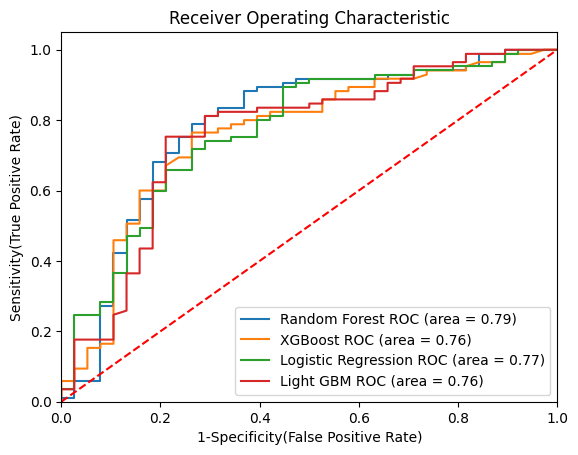

In [85]:
plot_multiplt_rocauc(models_balanced,X_Balanced_scaled2,y_balanced,  X_Test_scaled2, y_test)


### Choice


In [103]:
# Best model is Random Forest, since best on Precision, Recall, F1, AUC. 

model_RFC = RandomForestClassifier(max_depth=15, min_samples_leaf=4, n_estimators=200,random_state=42)
model_RFC.fit(X_Balanced_scaled2,y_balanced)

RandomForestClassifier(max_depth=15, min_samples_leaf=4, n_estimators=200,
                       random_state=42)

In [115]:
y_pred= model_RFC.predict(X_Test_scaled2)


# Model explenation

Using Lime for Local Model Explenation

In [145]:
predict_model_RFC = lambda x: model_RFC.predict_proba(x).astype(float)

In [158]:
explainer = LimeTabularExplainer(X_Test_scaled2.values, mode="classification", feature_names=X_Test_scaled2.columns)


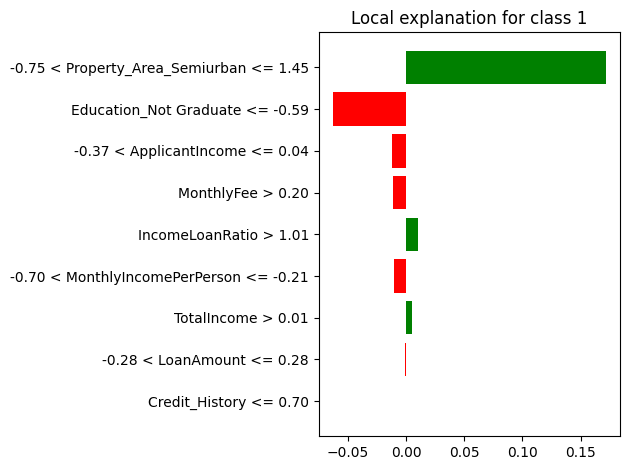

In [177]:
# Check variables for 3 value in test set. 
exp = explainer.explain_instance(X_Test_scaled2.iloc[37], predict_model_RFC, num_features=9)
exp.as_pyplot_figure()
plt.tight_layout()

In [170]:
# storing a new observation
i = 41
X_observation = X_Test_scaled2.iloc[[i], :]

# explanation using the random forest model
explanation = explainer.explain_instance(X_observation.values[0], predict_model_RFC)
explanation.show_in_notebook(show_table=True, show_all=False)
print(explanation.score)

y_test.iloc[i]

0.7969645301205195


1.0

# Save model

In [181]:
filename = 'finalized_model.sav'
pickle.dump(model_RFC, open(filename, 'wb'))